In [1]:
import requests
from IPython.core.display import HTML

# Assignment introduction

**Overview**
This is the first mandatory assignment in which you will implement a regression model to estimate where a person is looking (this is known as _gaze_) from images of eyes.
You have to hand in this Jupyter Notebook with your implementation and notes, see the bottom of this page for handin details. For the TA's to assess the assignment we kindly ask you to also hand in the `data`
 folder. If you are not comfortable sharing your data with the TA's leave that folder out for the handin, but provide the plots for assessment. Refer to the bottom of the page for submission details.
Before you start solving the assignment, carefully read through the entire assignment to get an overview of the problem and the tasks.
Notice that the optional Task 23 and onward relates to exercises in next week. You may save some time by postponing it until then.
**Note:** **Important!** Complete all tasks marked with **high (red)** priority before attempting to solve the others, as they are optional. Optional tasks and further analysis can help improve results, but feel free to explore methods and data as you choose.


The assignment builds on the Data preprocessing
 exercise using the data in the `data`
 folder as well as your own. You will start with the data of `test_subject_0`
. You will then try out the model using the data from the data collection session.
The assignment is structured in the following way:
- Train gaze estimation models using data from `test_subject_0`
 training set.    - Test the models using `test_subject_0`
 test set.
    - Test the models using `test_subject_3`
.


- Train gaze estimation models using data from `test_subject_3`
, `grid`
.    - Test the models using `test_subject_3`
. 


- Train gaze estimtion models using your own data set. 


**Note**
The assignment has multiple steps, but the procedures will repeat. Duplicate code as needed to keep results in each cell, making it easier to review during the exam.
To simplify the assignment, most visualization and data processing code is in `iml_util.py`
. You can review it, but you're not expected to explain it. Focus on the code provided in the assignment.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

**Note:** The location of the _fovea_ on the retina varies between people ($\pm$ 5 degrees). Consequently, a gaze model has to be trained (calibrated) for a specific person to be accurate. This difference is shown in [Figure 1](#kappa).

## Gaze Estimation introduction
Gaze estimation is performed by capturing images of a user's eye as shown in [Figure 2](#model) and mapping them to screen positions using a function $f_\mathbf{w}(x, y)$. Humans look at things by orienting their eyes so that the light from the point of focus hits the _Fovea_ (a point on the retina). The Fovea is not directly aligned with the center of the pupil, but at a person-specific angle, as shown in [Figure 1](#kappa). The pupil position can be used to infer gaze, but to obtain accurate gaze estimates requires training data (called calibration).


</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">



</div>


<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="kappa">

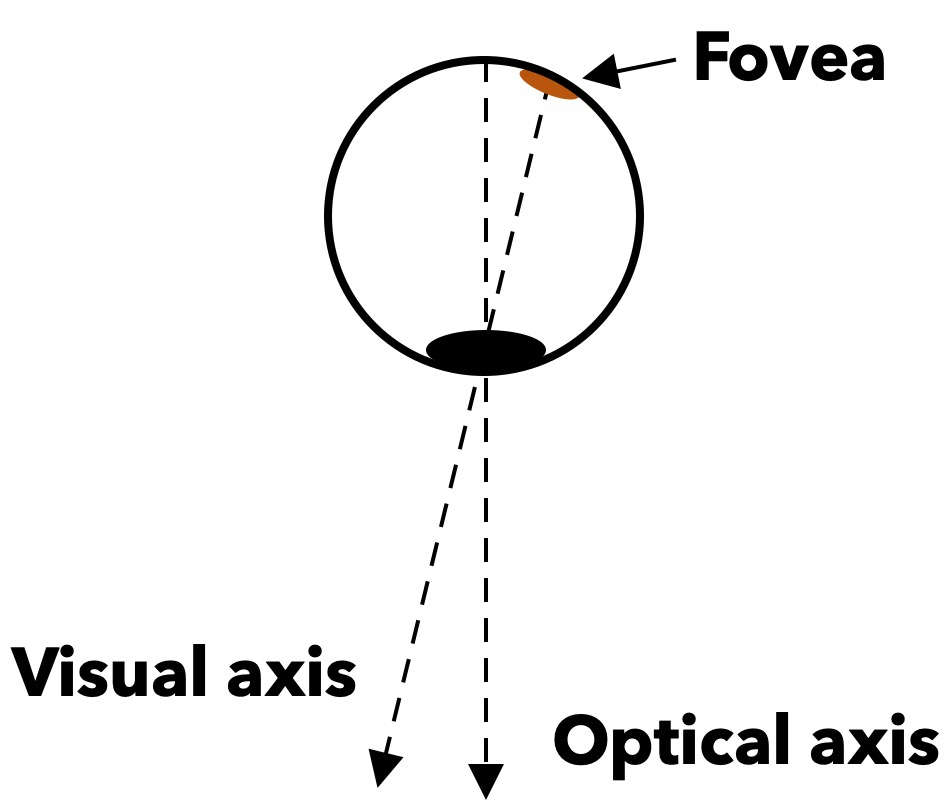

<figcaption class="figure-caption has-text-left">Figure 1: The distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis depends on the placement of the _fovea_.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

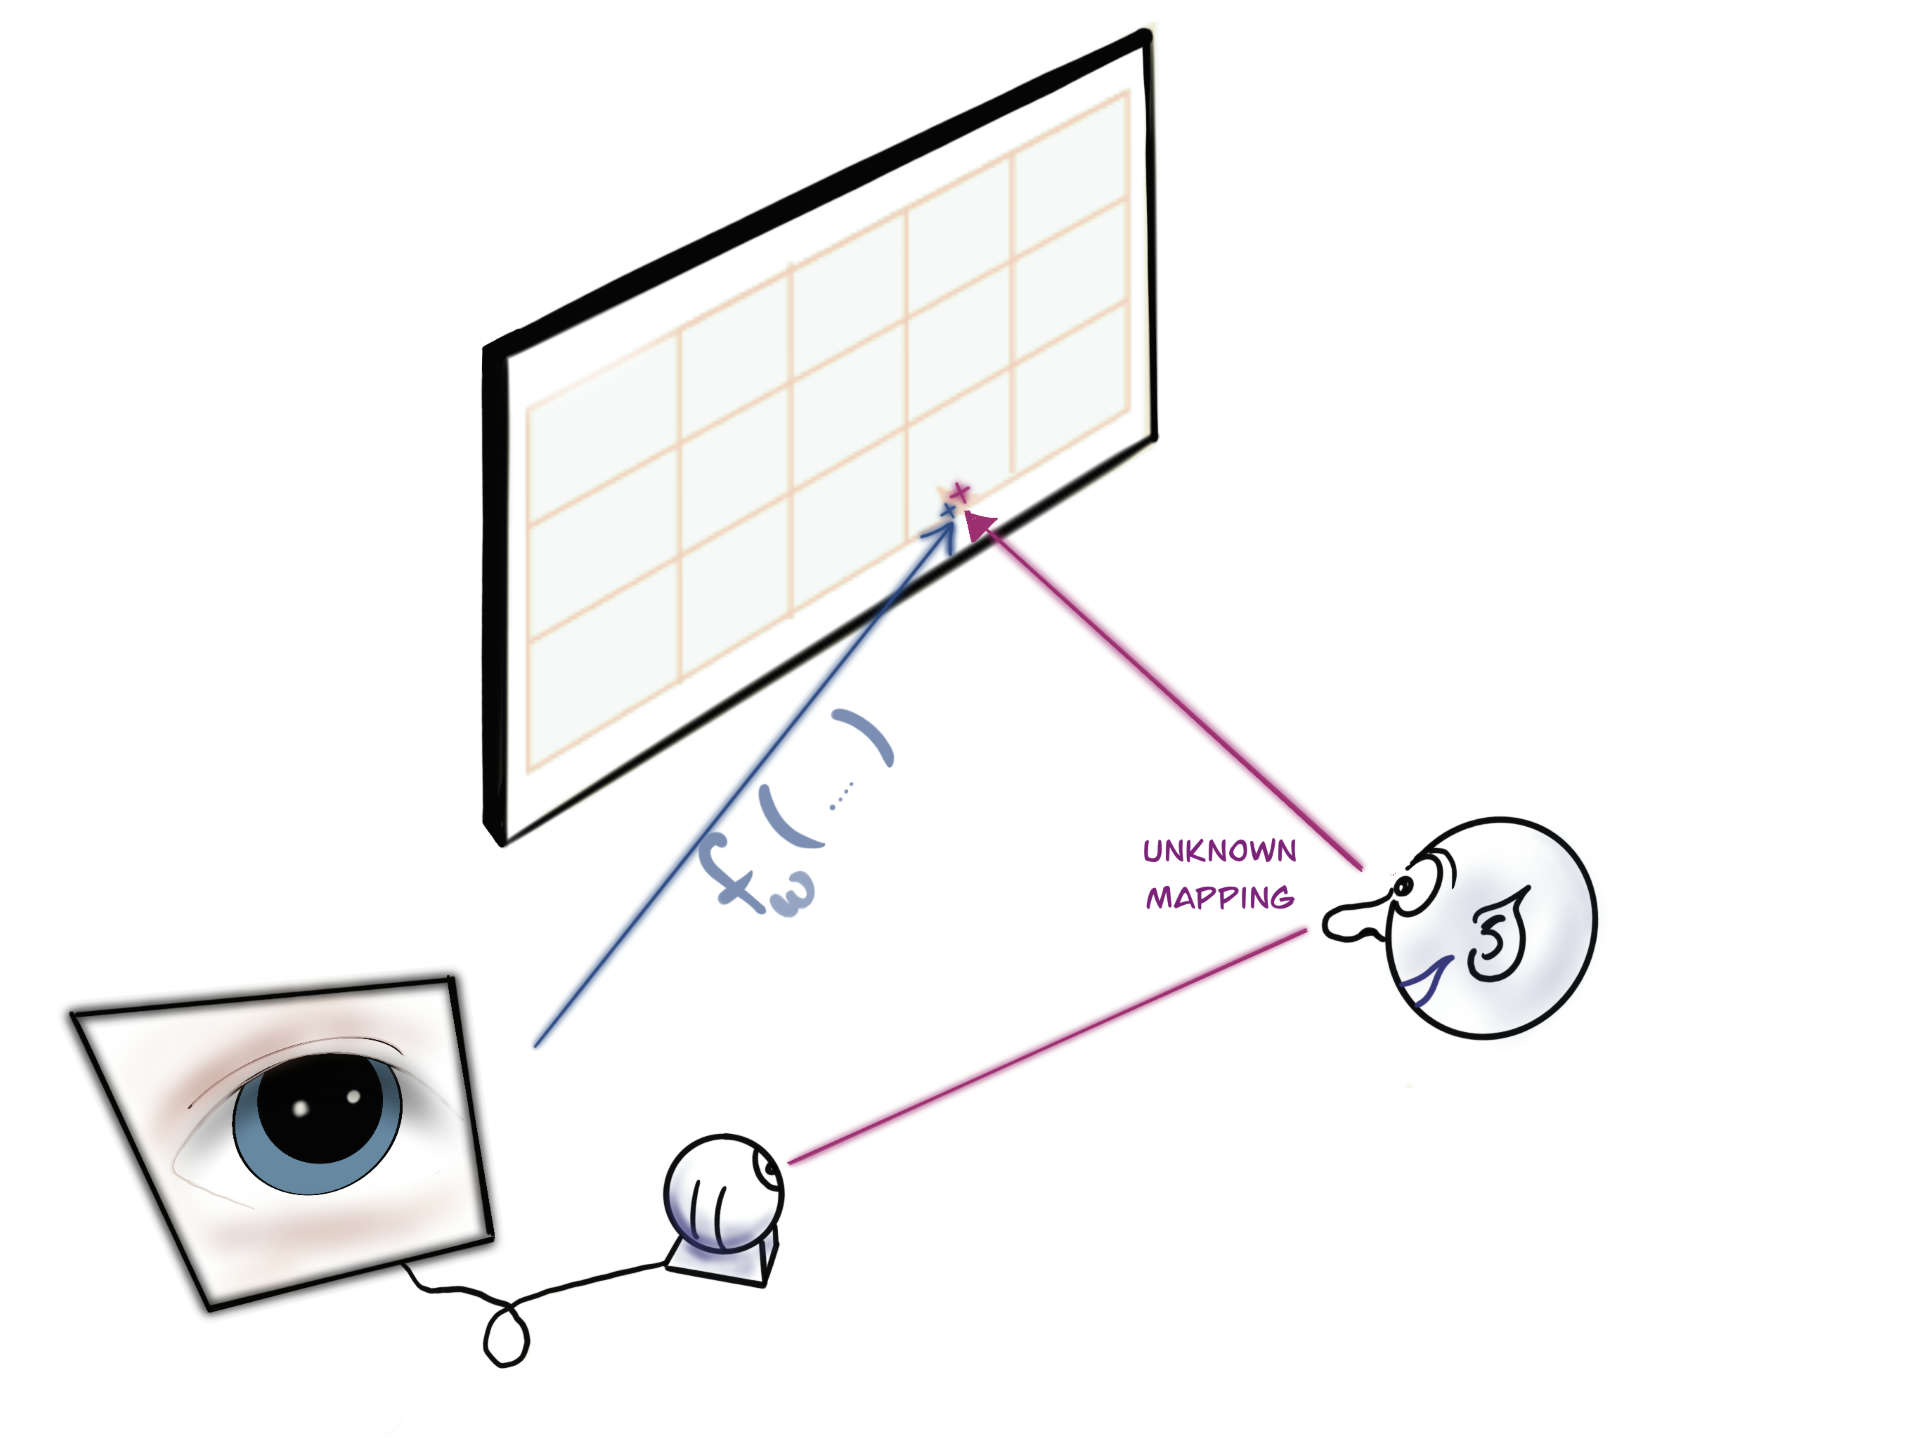

<figcaption class="figure-caption has-text-centered">Figure 2: Diagram of a gaze estimation system. The eye, which is directed at a specific point on
the screen is captured by the camera. The two red lines represent an unknown transformation from image
to eye and eye to screen. We learn this transformation directly which is shown as $f_{\mathbf{w} }(x, y)$ in the diagram.
</figcaption>
</figure>
</div>


</div>



</div>

### Gaze mapping function
The goal of this exercise is to estimate gaze from image sequences using a regression model. Define $f_{\mathbf{w}}(x, y)$ as the gaze  model which maps pupil positions $(x, y)$ to screen coordinates $(x', y')$. The model parameters $\mathbf{w}$ are learned from a training set containing paired pupil and screen positions. 
## Gaze estimation test subject 0
The first step is to train a gaze estimation model using the dataset of `test_person_0`
. You will:
- Train the models using the data `pupils_n_training`
 and `screen_coordinates_training`
. 
- Test the performance of the model using the `pupils_n_testing`
 and `screen_coordinates_testing`
. 

### Data and visualization

---
# Task 1 (easy): Data visualization👩‍💻
1. Inspect the structure of the dataset by revisiting exercise Data preprocessing
 section _Visualization_.
2. Run the cell below to visualize the data of `test_subject_0`
.


---

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import iml_util

D = iml_util.gen_data_subject_0()
for i in range(4):
    dataset = D[i]
    grid = iml_util.create_image_grid_viz(dataset)
    iml_util.image_and_scatter(grid, dataset)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\jgrum\\Documents\\Programming\\IML\\MachineLearning2024\\Exercises\\vscode\\W06\\data\\test_subjects\\test_subject_0\\gaze\\0\\normalized_pupils.csv'

## Implement a gaze estimation model
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 25%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="gaze">

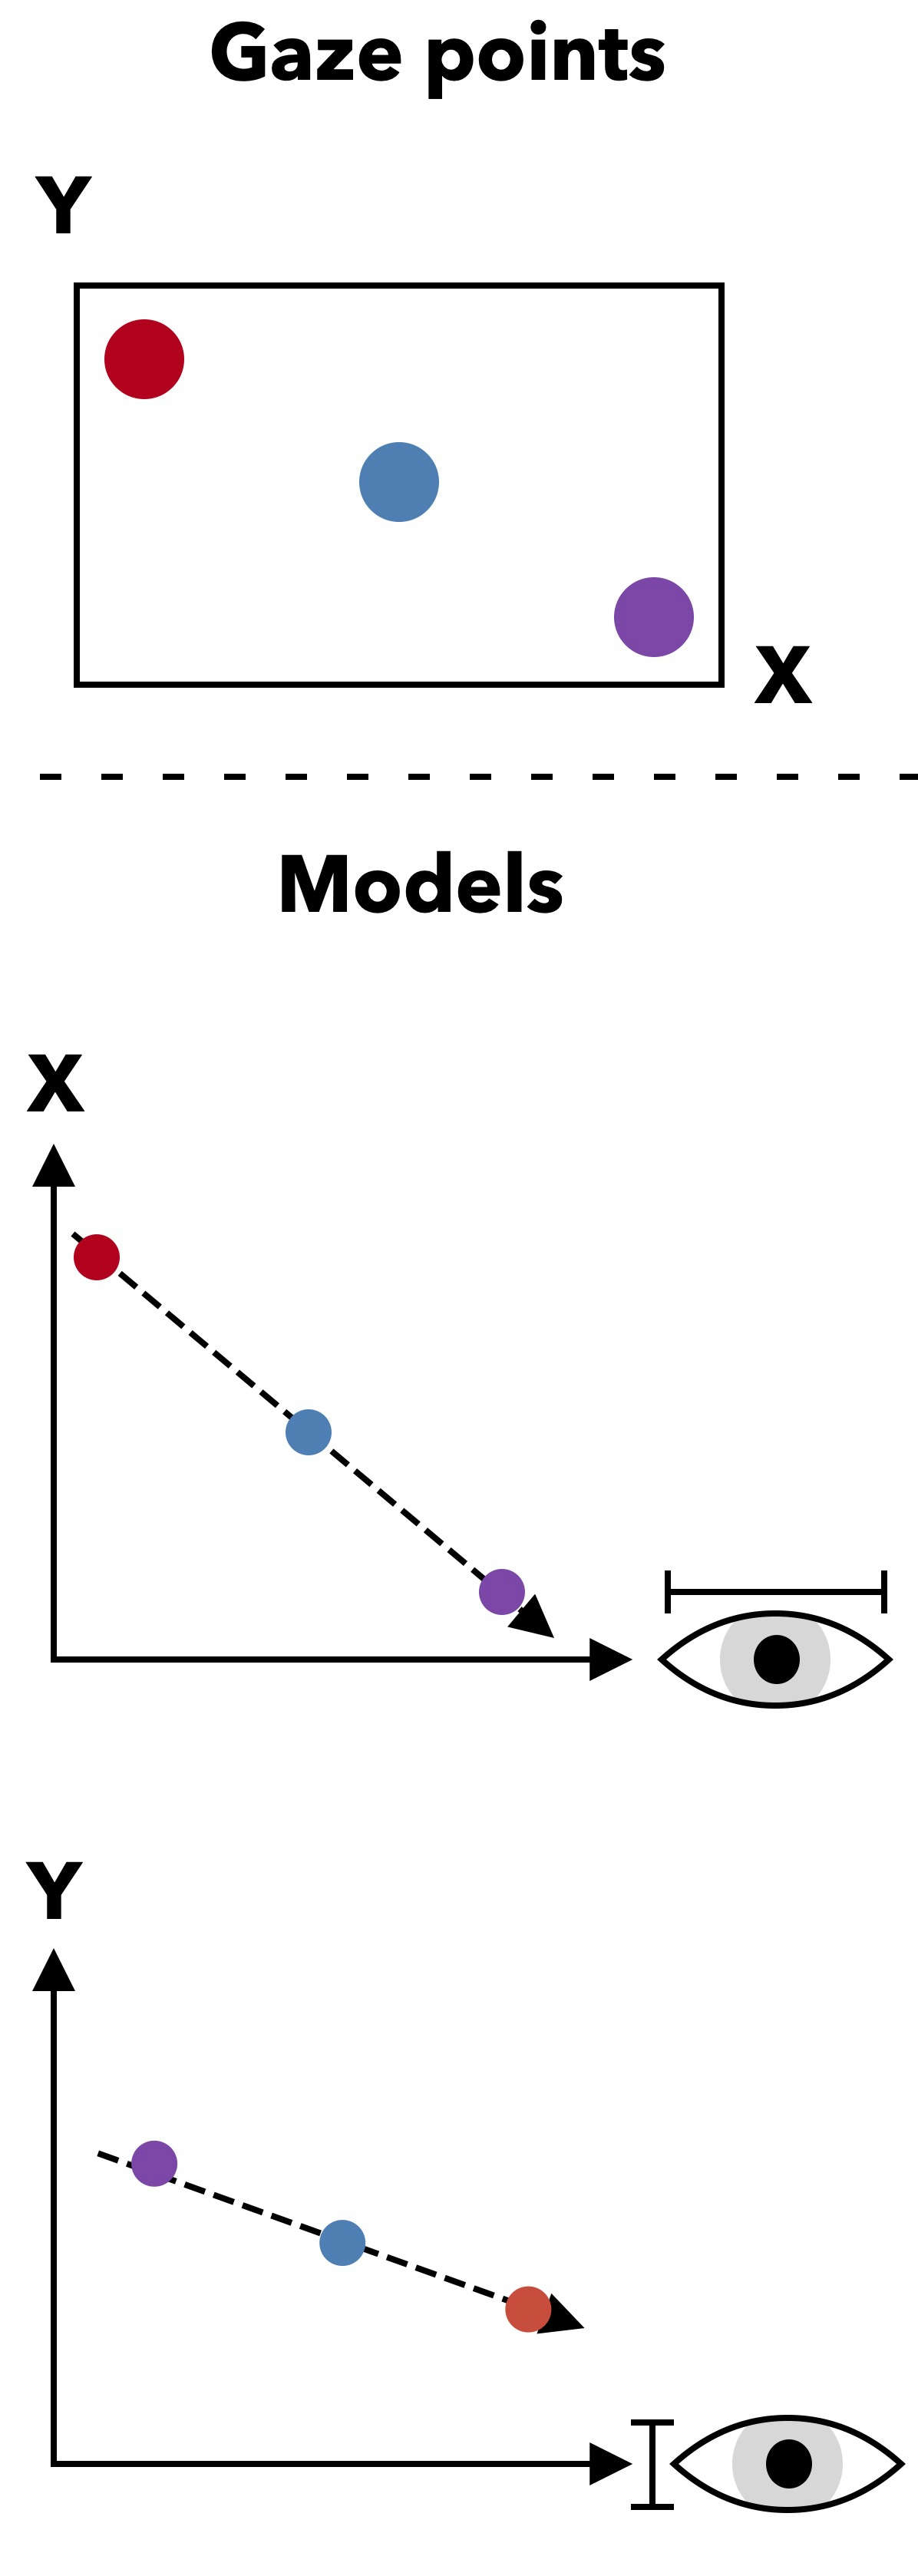

<figcaption class="figure-caption has-text-centered">Figure 3: Point mapping. Top: Three screen coordinates. Middle: Screen and eye $x$ coordinates for the same three points. Bottom: Screen and eye $y$ coordinates for the same three points.
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 75%; justify-content: start" class="block is-clearfix">

The true nature of the function that transforms pupil positions to screen positions is not easy to model. Even when the head is stationary, the relationship between pupil position in the image and gaze is non-linear due to the pupil's movement along a spherical curve. For now, we'll approximate the gaze mapping by using a linear function. 
Since the goal is to predict a $2D$ screen coordinate from a $2D$ pupil coordinate, it's more straightforward to train two separate models for each coordinate by following the pattern of previous exercises. The linear gaze model can be expressed as:struct

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f.
\end{aligned}
$$
Gaze mappings is demonstrated in [Figure 3](#gaze) to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both models estimating the $x$ position and $y$ position on the screen.

**Hint**
Use the previous exercise
 as a guideline.

In the upcoming tasks, you will be guided through the process of identifying essential entities necessary for establishing the linear equations required to learn the model parameters of the given model. The gaze model is divided into two distinct regression models, denoted as $x' = f_{w_1}(x, y)$ and $y' = f_{w_2}(x, y)$, each associated with its unique set of model parameters $w_1$ and $w_2$. Essentially, one model predicts the value of $x'$, and the other model predicts the value of $y'$. Follow the steps outlined below for the model $x' = f_{w_1}(x, y) = ax + by + c$, and subsequently, replicate the same steps for $y'$.
1. Identify model parameters and inputs to the model. We recommended that you use Least Squares from the numpy library [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
, it is recommended due to numerical stability. 
2. Isolate the unknown model parameters and the known into the design matrix.
3. Setup the linear equations $Aw=b$, where $A$ is the design matrix, $w$ the unknown model parameters and $b$ contains labels.



</div>



</div>


---
**Task 2 (medium): Initial reflection💡**
1. Identify the model parameters, inputs and outputs for the model.
2. Identify and determine the minimim number of data points needed to fit the model.
3. Using the least amount of points required to fit the model, does it matter which points are used? Why? Why not? 


---

## Reflection

Answer for 1:
![illustration](Illustrations/reflection.PNG)


Answer for 2:
We have 3 unknowns, so we need at least 3 points. 
This ensures that we can use either inverse matrix, which requires the matrix to be square,
or pseudo-inverse, which requires at least 3 points,

Answer for 3:
The points chosen, should represent the ground truth as well as possible.
If, lets say 3 outliers were chosen, we would end up with a very high error on our testing dataset.
What we want is low bias (ie. our line-fit should be as close to the ground truth as possible),
and also low variance (ie. we also get great results on unseen data, such as the testing dataset)



---
# Task 3 (medium): Implement a gaze model👩‍💻
**Note:** You can choose to train two separate models, to predict each screen coordinate separately, or you can train one model predicting both coordinates simultaniously. It may be slightly simpler to use two separate models.

1. **Design matrix:** Implement a function `get_design_matrix`
 to create the design matrix from an array pupil positions.

2. **Calibration:** Complete the implementation of the function `calibrate`
 of the class `LinearGaze`
.
    - Use the `pupils_n_train`
 and `screen_coordinates_train`
 arrays as training data. 
    - Use the function `get_design_matrix`
 to create a design matrix from the pupil positions. 
    - Learn the parameters $\mathbf{w}$ from the dataset using Least Squares. 


3. **Gaze estimation:** Finish the implementation of the function `predict`
 of the class `LinearGaze`
 which predicts the gaze point given a pupil position using the learned model parameters. For reference, the affine model has the form $f_\mathbf{w}(x)=\mathbf{w}_0 x_0 + \mathbf{w}_1 x_1 + \mathbf{w}_2$. You may calculate the point for each coordinate seperately. Return the estimated screen coordinates using the models created during calibration.


**Note:** **Important!** Don't expect the affine model to perform particularly well. Expect the distances between true and predicted gaze points to vary by $\pm 200$ pixels.


---

In [28]:
import numpy as np

def get_design_matrix(pupil_positions):
    """
    Constructs a design matrix.

    Parameters:
    pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).
    
    Returns:
    design_matrix (N x 3 numpy array): n_samples, 2 features + 1
    
    Example:
    If pupil_positions are [x, y], the output is [1, x, y]
    """
    # Return the design matrix [1, x, y] for each row
    #This works, because pupil_positions is in itself 2 columns in the correct order x,y
    #And then we add a first column with 1's, which is the bias term
    return np.c_[np.ones(pupil_positions.shape[0]), pupil_positions]

def linear(params, x):
    """
    Computes the linear transformation of the input x using the given parameters.
    
    Parameters:
    params (1 x 3 numpy array): Coefficients for the linear model [bias, weight_x, weight_y].
    x (1 x 2 numpy array): Input vector [px, py].
    
    Returns:
    float: The linear combination result.
    """
    # params[0] is the bias term, params[1]*x[0] + params[2]*x[1] represents the linear transformation.
    return params[0] + params[1]*x[0] + params[2]*x[1]

class GazeModel:
    def calibrate(self, dataset):
        ...

    def predict(self, pupil):
        ...

    def predict_many(self, pupils):
        return np.array([self.predict(pupil) for pupil in pupils])


class LinearGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates 
        based on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data.
            pupil_training_set (str): Key to access the pupil training data from the dataset.
            screen_training_set (str): Key to access the screen coordinate training data from the dataset.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on the least squares solution.
        """
        
        #notice it is a string, called with pupil_n_train, as required for assignment 2
        #The labels exists in the screen_train, which is the output
        pupils_train = dataset[pupil_training_set]
        #The labels exists in the screen_train, which is the output
        screen_train = dataset[screen_training_set]
        
        # Construct the design matrix [1, x, y] for each pupil position
        A_design_matrix = get_design_matrix(pupils_train)
        
        #This takes all rows, and column 0 which is x
        output_X = screen_train[:, 0]
        #column 1 is y
        output_Y = screen_train[:, 1]
        
        # Use least squares (pseudo-inverse) to solve for weights
        self.model_x, _, _, _ = np.linalg.lstsq(A_design_matrix, output_X, rcond=None)
        self.model_y, _, _, _ = np.linalg.lstsq(A_design_matrix, output_Y, rcond=None)

    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            (float, float): Predicted gaze position (x, y) based on the linear model.
        """
        
        #El classico of a linear transformation.
        #Aw = y
        #A = design matrix
        #w = model
        #y = output
        predicted_x = linear(self.model_x, pupil)  # Predict x coordinate
        predicted_y = linear(self.model_y, pupil)  # Predict y coordinate
        
        return predicted_x, predicted_y


## 3. explained in details


**CALIBRATION**

image this.
We now have our matrix consisting of our inputs, and we also know some desired outputs.
We now want to learn what to set the coeffiecents in our formula, such as the inputs can hit the desired outputs.

There are different ways to do this.
Lets assume we have 3 points (eye coords), with 3 points (screen coords)
A= input: eye coords.
w= weights in formula, that can be used linearly transform our input to output
b= output: screen coords.

Aw = b
w = A^-1b


Lets assume we could draw a straight line through these points.
But that might not be what we want, for several reasons.
1.This might be an overfit, with perhaps biased points, where the ground truth might be very different.
2.If we drop the assumption, that a straight line will exactly fit through these points, as the case often is, then
we will see that our matrix is not inverible, and thus not able to solve the formula above.

We need some kind of line, that minimizes the distance between all the points, and the line we draw.
Here enters the pseudo-inverse (least squares), which is a projection of all the points to the line, making 
the squared distance between all the points, as low as possible. We square the distance, so we always
get positive values, so it doesn¨t matter which orientation they stray away from the line.

We can now solve the formula above, and make the calibration of our weights.

**PREDICTION**

Now that we know:
A: Our inputs.
w: our learned weights, from the calibration.
b: our prediction based on the inputs.

We can simply do a normal linear transformation of: Aw = b


HUSK AT OPDATER ILLUSTRATION OG TEKST
![illustration](Illustrations/version2.PNG)





---
# Task 4 (medium): Model evaluation👩‍💻💡
The following task is about evaluating the performance of your models. In the following task you will complete the function `results_for_model`
. It is important that the results are calculated for the complete dataset of `test_subject_0`
 (all of $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ as one dataset).
1. Finish the implementation of the function `results_for_model`
. For each dataset it must:    - **Calculate prediction errors:**         - Calculate:            - The _absolute error_ between each prediction and true gaze.
            - The _mean Eucledian distance_ between the true values and the predictions.
            - The _root-mean-square error_ (_rmse_) between the true values and the predictions.
            - The _mean absolute error_ (_mae_) as well.








---

In [29]:
import numpy as np

def results_for_model(model, dataset_train, dataset_test, pupil_training_set, screen_training_set, pupil_test_set, screen_test_set, d_max):
    """
    Evaluates the performance of the model across multiple datasets and computes prediction errors.

    Parameters:
        model (object): A gaze model object.
        dataset_train (dict): Dictionary of training data.
        dataset_test (dict): Dictionary of test data.
        pupil_training_set (str): Key for accessing pupil training set in datasets.
        screen_training_set (str): Key for accessing screen coordinate training set in datasets.
        pupil_test_set (str): Key for accessing pupil test set in datasets.
        screen_test_set (str): Key for accessing screen coordinate test set in datasets.
        d_max (int): Maximum number of patterns of a dataset to evaluate.

    Returns:
        results (dict): A dictionary where each key corresponds to a dataset index (0 to d_max-1), 
                        and each value is a dictionary containing:
            - "predicted" (N x 2 numpy array): Predicted gaze positions.
            - "ground_truth" (N x 2 numpy array): Actual gaze positions.
            - "errors" (N x 2 numpy array): Absolute errors between predicted and ground truth positions (x, y).
            - "rmse" (float): Root Mean Squared Error (RMSE) for the predictions across the dataset.
            - "dist" (float): Mean Euclidean distance between the predicted and actual positions.
            - "mae" (1 x 2 numpy array): Mean absolute error in x and y dimensions.
            - "model_x": Coefficients for x-coordinate model.
            - "model_y": Coefficients for y-coordinate model.
    """
    
    #Map to store and return results!
    results = {}
    
    for dataset_index in range(d_max):
        
        #Our datasets along with the actual ground truth
        train_data = dataset_train[dataset_index]
        test_data = dataset_test[dataset_index]
        ground_truth = test_data[screen_test_set]
        
        #We only train on the training data.
        model.calibrate(train_data, pupil_training_set, screen_training_set)
        
        #Here we are utilizing our testing dataset, to get the predicted values for it.
        #This is to find our errors, measured against the ground truth.
        predicted = model.predict_many(test_data[pupil_test_set])
        
        #Errors is a matrix of x and y, 
        #where we have the absolute difference between predicted and ground truth for each sample.
        abs_errors = np.abs(predicted - ground_truth)
        
        #A bit similar to above, but instead we summarize the squared errors (ensuring positive values), 
        #take average into a single value, and use square-root to get it back to same scale as the original data.
        rmse = np.sqrt(np.mean((predicted - ground_truth) ** 2))
        
        # Euclidean distance between predicted and ground truth.
        dist = np.mean(np.linalg.norm(predicted - ground_truth, axis=1))
        
        #Similar to RMSE, but we take the mean of the absolute errors, 
        #to get a single value.
        mae = np.mean(abs_errors, axis=0)
        
        results[dataset_index] = {
            "predicted": predicted,
            "ground_truth": ground_truth,
            "errors": abs_errors,
            "rmse": rmse,
            "dist": dist,
            "mae": mae,
            "model_x": model.model_x,
            "model_y": model.model_y
        }
    
    return results



def print_results_pretty(results):
    # Header
    print(f"{'Dataset':<10}{'RMSE':<10}{'Mean Distance':<15}{'MAE (X)':<10}{'MAE (Y)':<10}")
    print("-" * 50)
    
    for dataset, metrics in results.items():
        rmse = metrics["rmse"]
        dist = metrics["dist"]
        mae_x = metrics["mae"][0]
        mae_y = metrics["mae"][1]
        
        print(f"D{dataset:<9}{rmse:<10.2f}{dist:<15.2f}{mae_x:<10.2f}{mae_y:<10.2f}")



#Parameters:
#1. Create a linear model
#2. Train it on the training data D
#3. Test it on the testing data D
#4. Use pupil_n_train as the TRAINING data for the pupils
#5. Use screen_coordinates_train as the TRAINING data for the screen coordinates
#6. Use pupil_n_test as the TESTING data for the pupils
#7. Use screen_coordinates_test as the TESTING data for the screen coordinates
#8. Run this for 4 datasets (grid:0, circle:1,random:2, line:3)
results_linear = results_for_model(LinearGaze(), D, D, 'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)

print_results_pretty(results_linear)


Dataset   RMSE      Mean Distance  MAE (X)   MAE (Y)   
--------------------------------------------------
D0        126.85    165.62         146.19    63.13     
D1        98.95     134.17         115.10    60.91     
D2        72.92     96.46          57.62     64.51     
D3        94.84     122.52         62.93     92.17     


## 4. explained in details

**ERRORS**:
Now that we can make a prediction, based on our inputs and our least squares fit.
We can compare how our predictions, are close to the actual ground truth,
which in our case are the fixed screen coordinates, used in the eye-recording session.
We can use coordinates, not seen by the least squares training calibration,
being our testset, to make a prediction and measure against the ground truth.
A low variance, means that our prediction is close to the truth,
whereas a high variance, means that our predictions vary a lot from the truth.
There are different ways, to look at the difference between prediction and truth.
Such as the absolute value, giving a very linear result. 
or root mean squared error, which punishes outliers, because the difference is squared, before taking
the mean and then doing a root, to get the values back to original units.

Below you find a cell containing a function for visualizing the performance of the model. 

---
# Task 5 (medium): Visualize performance of your model👩‍💻
1. **Create visualizations:** Run the cell below to visualiz the performance of the model for all patterns using the function `plot_results_grid`
 from `iml_util.py`
. The function takes a dictionary of results as well as the number of patterns in the dictionary. Combined they provide an overview of the nature of the error across the two dimensions.


---

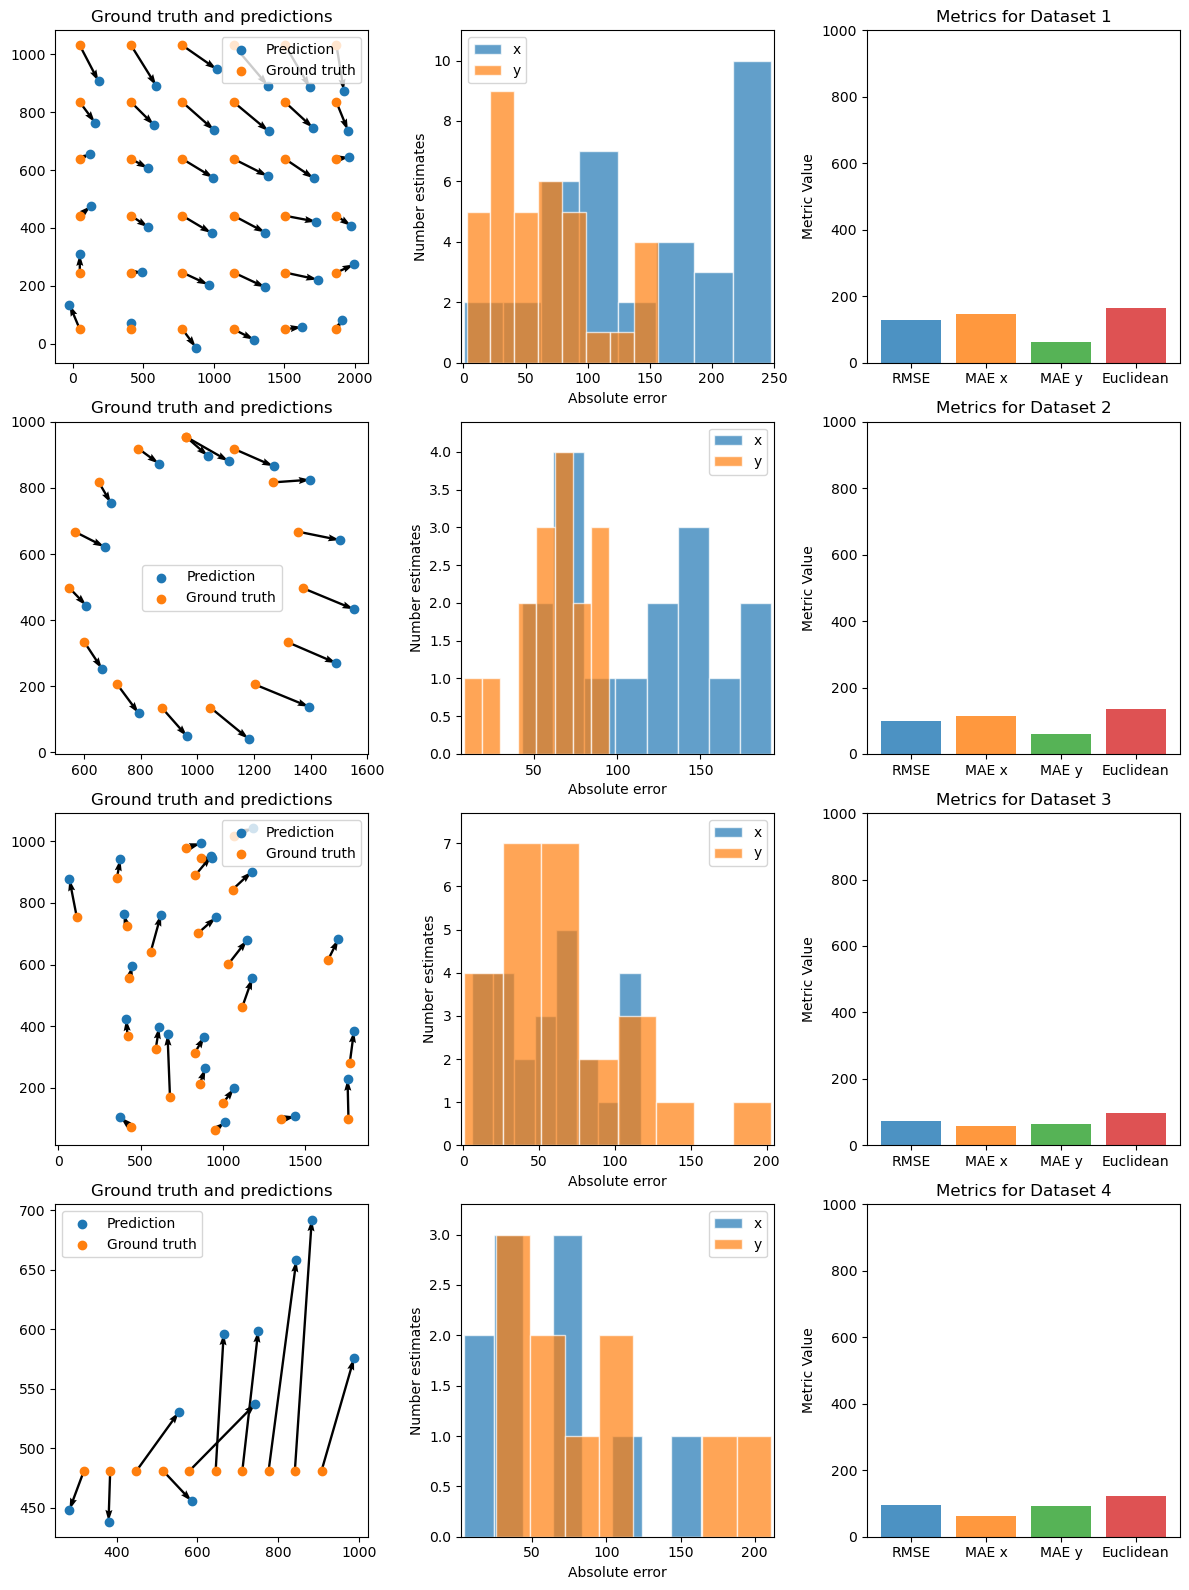

In [30]:
iml_util.plot_results_grid(results_linear, 4)

#LEFT IMAGE:
#Our model which has been trained on a training set, making predictions colored blue.
#On testing set, which represents the ground truth, colored orange.

#MIDDLE IMAGE:
#Histogram. One bar for example shows that, y: 8 different points had an abs_error between 25 to 45

#RIGHT IMAGE:
#Bar chart. Showing different representations of the errors.


---
# Task 6 (medium): Evaluate performance of your model💡
1. Evaluate the usefulness of the _mae_ or _rmse_ and their differences.
2. Identify at least 3 potential sources of error associated with the current affine model. Describe how each source of error contributes to the prediction error.


---

## 6.1: Usefulness of mae vs rmse

**MAE**, takes the absolute error, meaning it doesn't care about if it is over or under-estimates its prediction.
It also gives the result in the same unit, as the actual data, and is therefore a very linear result.

**RMSE**, almost achieves the same, but instead it utilizes square root, which punishes outliers more.
Or as Thore from algorithms would say, O(N^2) scales harder than O(N).
This is useful if you are interested in weighting outliers harder, for error consideration.

Having both numbers is therefore great, because if there is a significantly higher RMSE than MAE, it
indicates that the dataset had many outliers.


## 6.2: 3 sources of errors

1. Complexity of model. If our equation utilized, such as if we were to make it a completely linear model, f(x) = ax, then
it would have high bias, as it would be unable to capture the non-linear reality of eyes. Thus if using wrong complexity
of the model, we could end up with a higher prediction error.

1. Recording of data. If the recorded data has too much noise from head movement, blinking, or shaking of camera.

2. Processing of data. If our algorithm for pupil detection, wrongfully detects a non-pupil as a pupil.

You have now went through the first part of the assignment processing the session of `test_subject_0`
. The remaining part of the assignment use the same approach as you have just gone through with the purpose of you working with and reflecting on the use of your own data collected. 
## Test on test subject 3
In the data processing exercise Data preprocessing
 the pupil corrdinates `mean_pupil_coordinates.csv`
 and the corresponding screen coordinates `screen_coordinates.csv`
 were saved in the in the folder with the test subjects and patterns. Recall the four calibration patterns used for the data collection being **grid**, **circle**, **line** and **random**.
In this exercise you will use the calibration (training data) of `test_subject_0`
 on the data from `test_subject_3`
 and visualized in [Figure 4](#calibration).
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="calibration">

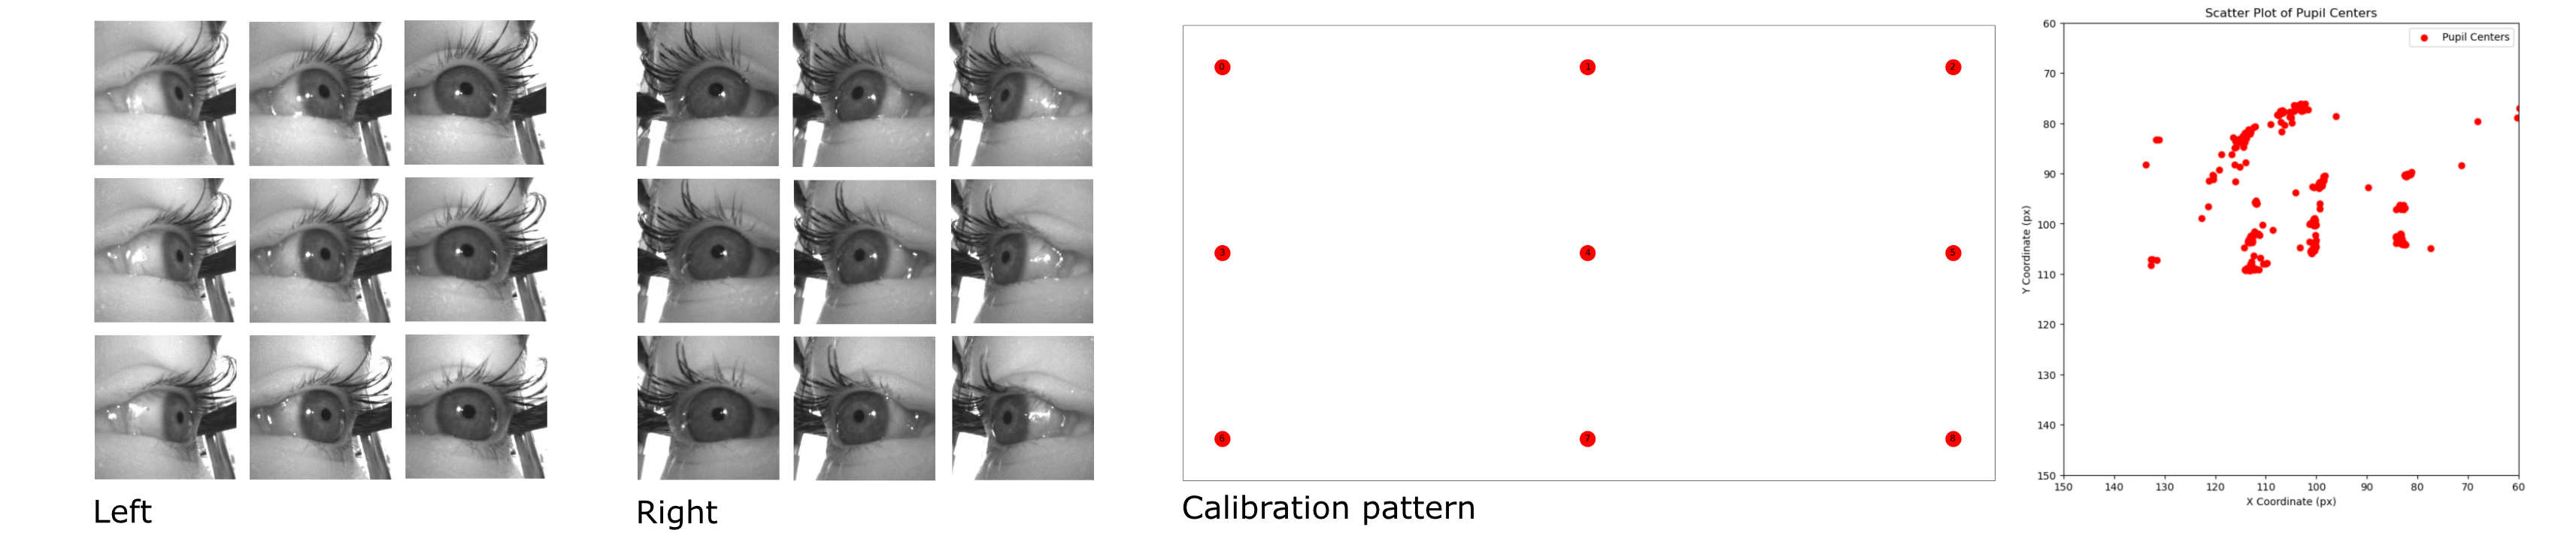

<figcaption class="figure-caption has-text-centered">Figure 4: Left: Images fron calibration pattern grid. Middle: Calibration pattern. Right: Pupil center scatterplot from calibration pattern grid.</figcaption>
</figure>
</div>


</div>


---
# Task 7 (easy): Load the data👩‍💻
1. Run the cell below to load the data of `test_subject_3`
. _Similarily_ to the data of `test_subject_0`
 meaning that the `grid`
 pattern is defined as training set for all other patterns. The data is stored as a list of dictionaries in the following order: `grid`
, `circle`
, `line`
, and `random`
. Within each dictionary you find: 


**Details about the data format of `test_subject_3`**
**Dataset elements:**
- `pupils_train`
: Mean pupil positions for the 9 calibration points from `grid`
 pattern (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration points from `grid`
pattern ($9 \times 2$ array containing x,y pixel position for the target on the screen (`sx`
, `sy`
)).
- `pupils_test`
: Mean pupil positions for the calibration points for the pattern accociated as the key(an $N \times 2$ array containing the $N$ x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the N calibration points associated to the pattern defined as the key ($N \times 2$ array containing the $N$ x andy pixel positions for the target on the screen (`sx`
, `sy`
))



---

In [31]:
D3 = iml_util.gen_data_subject('test_subject_3')


---
# Task 8 (easy): Visualize performance👩‍💻
1. Run the cell blow to evaluate the gaze estimation model using the `pupils_grid`
 data from `test_subject_3`



---

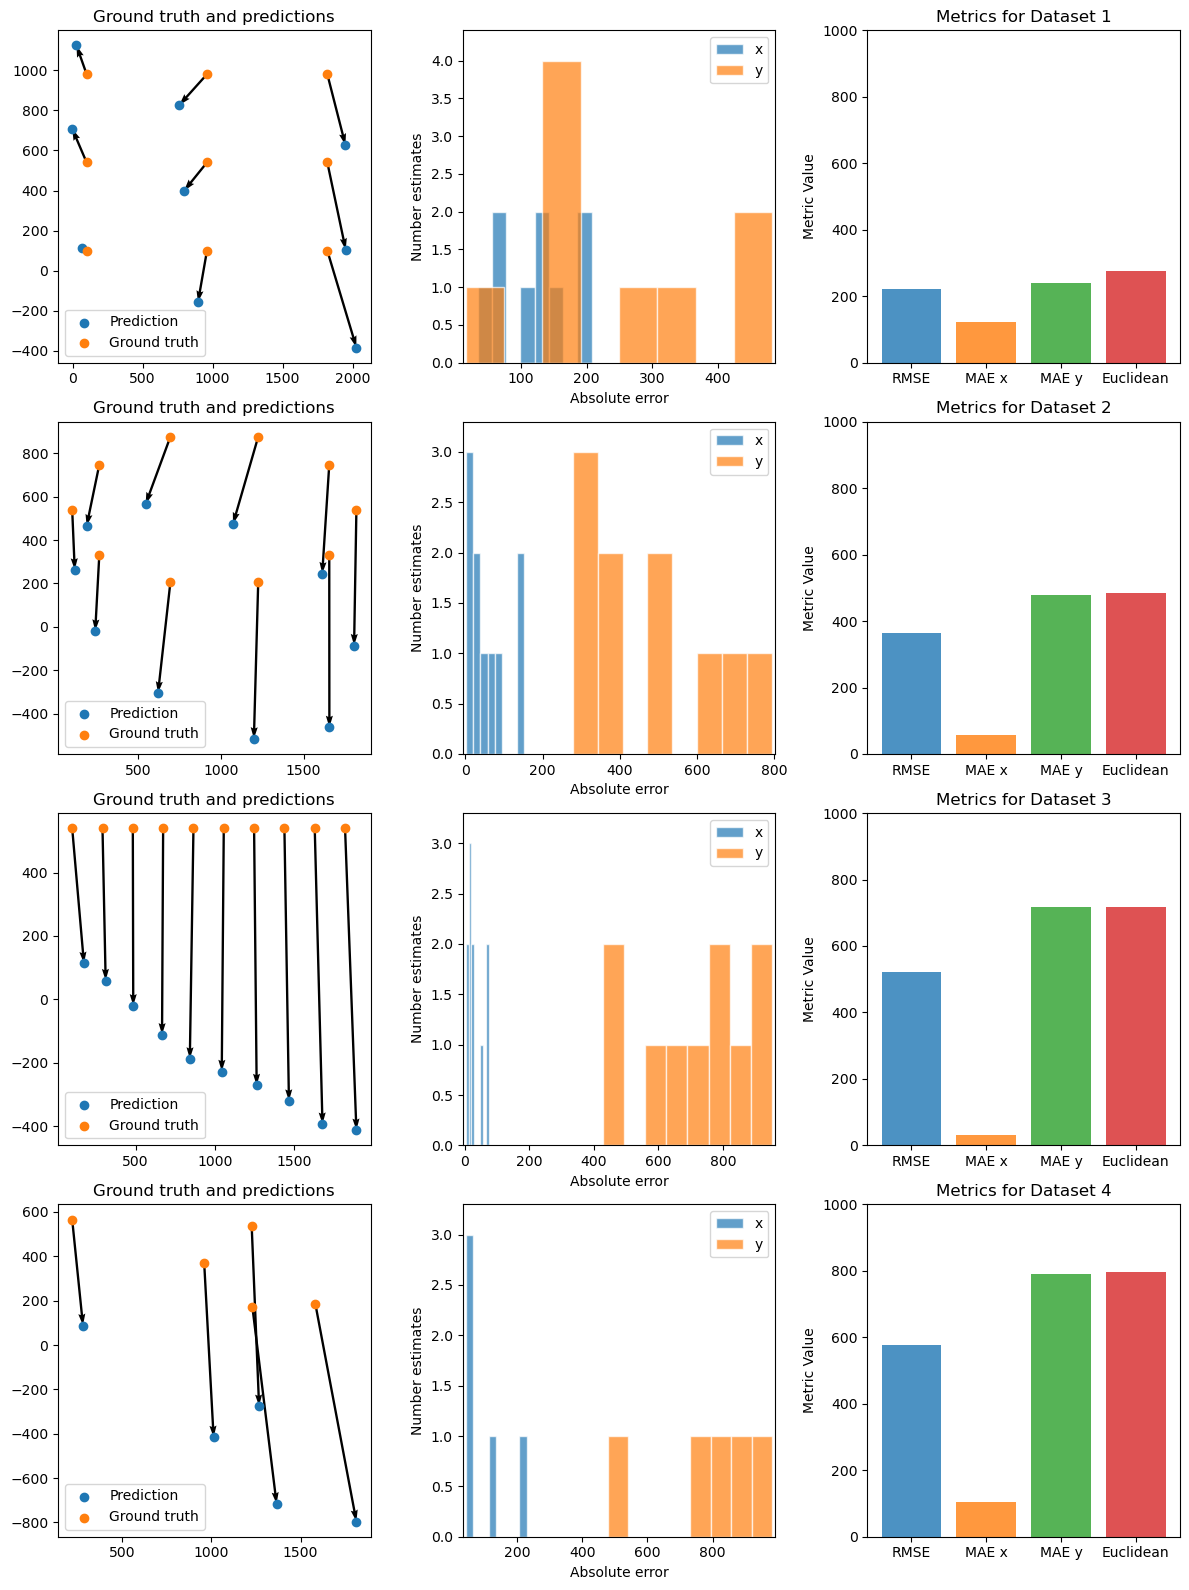

In [32]:
#We use a linear model, train on dataset 0 (D), and test on dataset 3 (D3)
results_linear_ts3 = results_for_model(LinearGaze(), D, D3, 'pupils_n_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_ts3, 4)


---
# Task 9 (medium): Evaluation♾️💡
You likely have observed larger prediction errors, including the `MAE_y`
 and `RMSE`
. Reflect on:
1. How well does the model predict gaze of `test_subject_3`
?
2. Use your reflections in Task 8 in the exercise Data preprocessing
 to elaborate on the results in this exercise.
3. Comment on differences between the predicted `x`
 and `y`
 coordinate.


---

## 9.1 How well does model predict gaze of test_subject_3

Because we train on the eye of test subject 0,
but uses the test data of subject 3, we have a higher error, compared to earlier.
This is because there is an inductive bias, towards the eye-behaviour of subject 0,
which might be different than the behaviour of subject 3.
The errors have in generally doubled, from when only using data from test subject 0.

## 9.2 Evaluation of the model

The difference between RMSE and MAE, is generally low, indicating a low amount of outliers.
Most of the errors, comes from noise, both structured and unstructured.
Structured: Slighly different angle towards the camera between the subjects.
Unstrucutred: Slight shaking of equipment.

When this model saw unseen data from test subject 0 in exercise 4, it generally
performed okay, but when seeing unseen data from test subject 3,
it had a marginally higher error. This might lead to the conclusion, that the model is poor at generalization.

## 9.3
Most of the results are skewed on the y-axis, which might
indicate a different eye-behaviour between test subject 0 and 3, such as
position of the fovea. If one subject has to look at ex. 5 % lower angle,
to look at the same spot, then the data will be skewed 5 % on the y-axis between subjects, for the 
same ground truth "fixed screen coordinates".


## Gaze estimation test subject 3
In this the gaze estimation model is trained using the `grid`
 pattern of `test_subject_3`
, and test it on the patterns. 

---
# Task 10 (easy): Train and test a model👩‍💻
1. Use `result_for_model`
 to train and test a gaze estimation model based on `test_subject_3`
.
2. Use `plot_results_grid`
 to visualize the result.

**Note:** The result using pupil centers from the `grid`
 pattern is a result of training and testing on the same data.


---

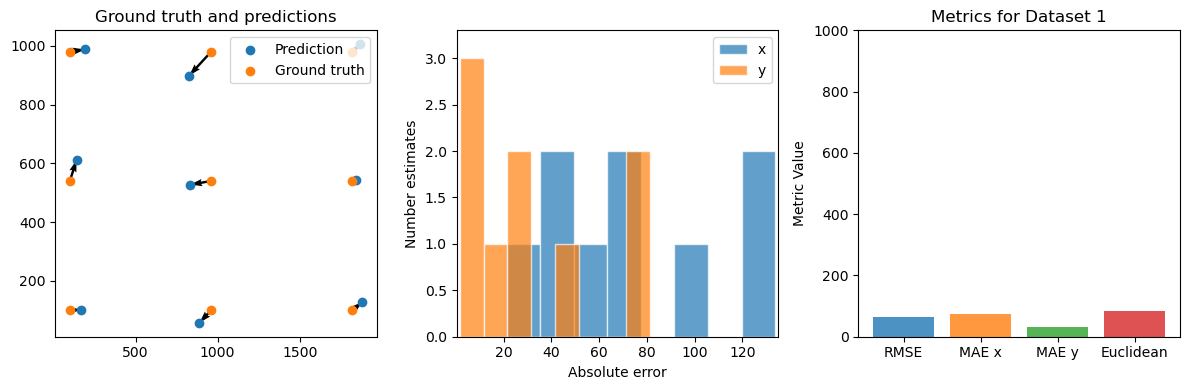

In [34]:
grid_data_train = D3[0]
# Testing on the same grid pattern
grid_data_test = D3[0]

results_grid = results_for_model(
    model=LinearGaze(),  
    dataset_train=[grid_data_train], 
    dataset_test=[grid_data_test],
    pupil_training_set='pupils_train',
    screen_training_set='screen_coordinates_train',
    pupil_test_set='pupils_test',
    screen_test_set='screen_coordinates_test',
    d_max=1# Only testing on the grid pattern (1 dataset)
)

#Visualize only 1 grid
iml_util.plot_results_grid(results_grid, 1)




---
# Task 11 (easy): Evaluation💡
1. Reflect on the result testing the model on `test_subject_3`
.     - Use your reflection from Task 8 in exercise Data preprocessing
 to elaborate on the result.        - Why does the performance of the model trained on `test_subject_3`
 show significantly larger prediction errors compared to the one trained and tested on `test_subject_0`
?






---

## 11 - Reflection - TODO SPØRG TA

SE LEARNIT FOR SVAR

You may by now you have observed that the model is struggling with properly predicting the `y`
 coordinates. The cell below visualizes the model predictions separating the `x`
 and `y`
 coordinate.

---
# Task 12 (easy): Evaluation(continued)♾️💡**
1. Run the cell below to viualize the models independently. 
2. Use the plot for further evaluation, reflect on the questions:    - Observe that the model are struggling the most in predicting the `y`
 coordinate correctly. What is a possible explanation for this? 
    - What would happen to the plane if we train the model on more data points?



**Note:** Incoorporate your reflections from exercise Data preprocessing
 Task 8.


---

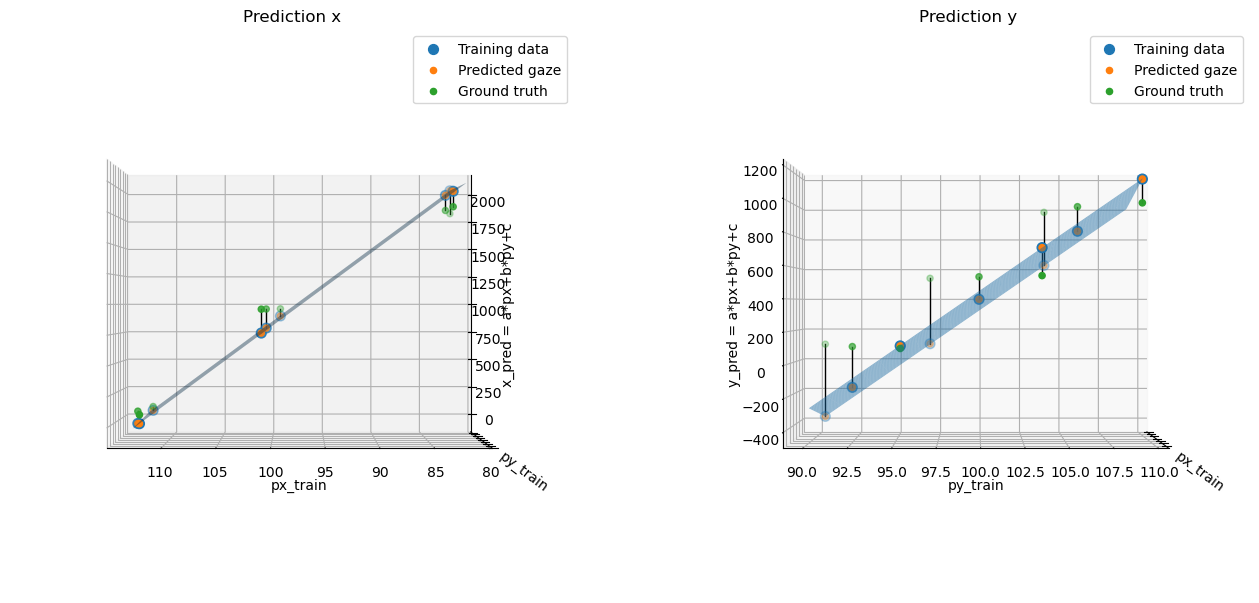

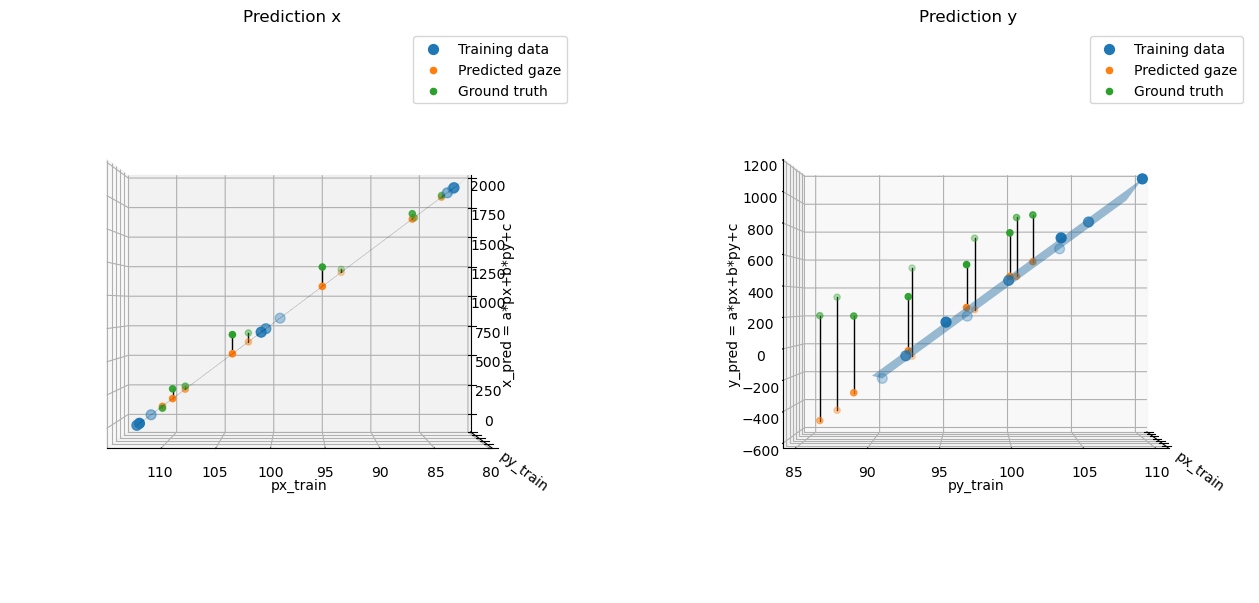

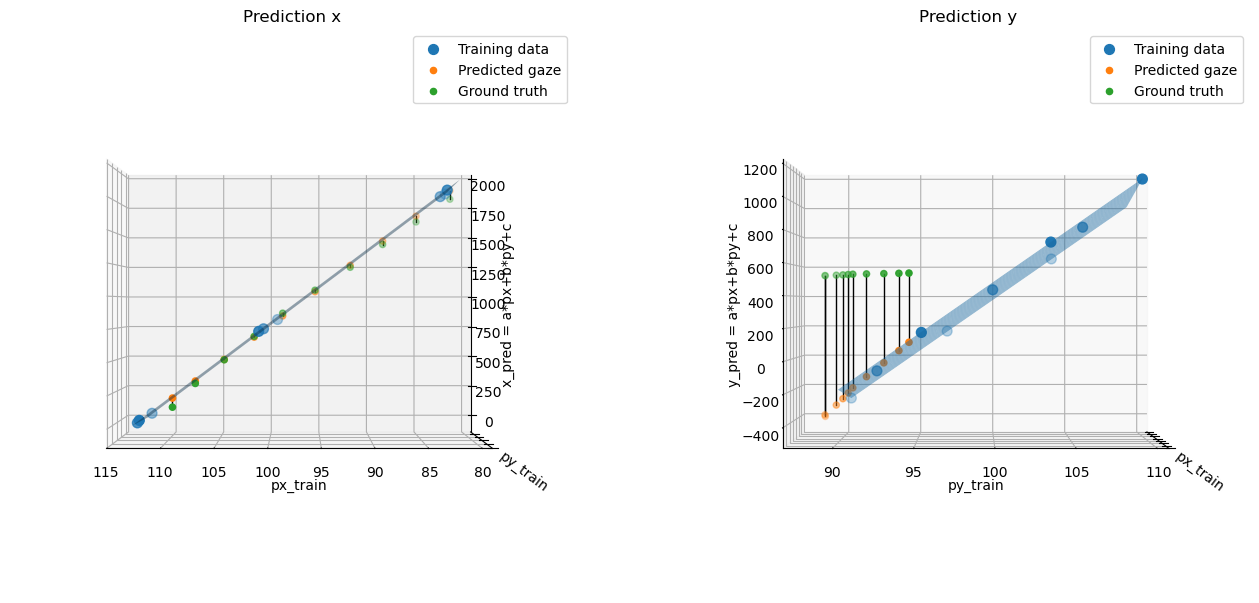

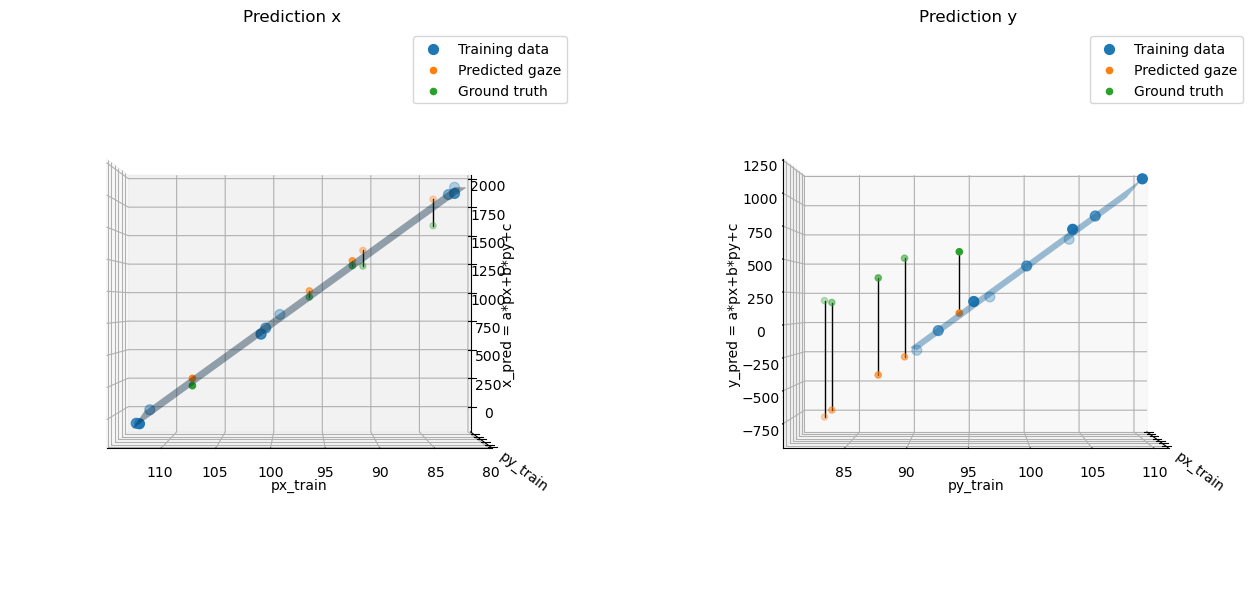

In [35]:
for i in range(len(results_linear_ts3)):
    iml_util.plot_from_results_dict(results_linear_ts3[i], D3[i])

## 12.1 Visulization analysis.

(using x_prediction graph as example) 
In the bottom of the graph, we can see "x" (sideways "axis") and "y" (depth "axis"), these are known values.
Given those values, we predict where we are looking "x'"(vertical "axis"), these predicted values
for coordinate x, are seen on the right of the graph.

Blue plane: Our predictions, indicated by the prediction formula written to the side of the graph.

## 12.2 Why is model struggling on y-coordinate predictions
Left side graphs: x coordinates, where we can notice how the error is very low.

But on the right side graphs, where we predict y coordinates, we notice how the error is high.
Possible reasons for this:
Pupil horizontal position (x) might behave more like a linear function than vertical position (y) does. 
The x coordinates may vary more in value than the y coordinates. So in order to calculate least squares we must favor x coordinates because outliers are punished harder. It is also easier to find a model that is fairly close to the y coordinates compared to the x coordinates because they generally are closer together. This also means that the y coordinate is more sensitive to small changes which our model does not take into account.







To further elaborate on the prediction of the `y`
coordinate, the cell below visualizes the  _Sum of Squared Error_ (SSE) loss function, in parameter space. 
The cell below creates two plots, left is the loss when changing parameters `a`
 and `b`
 while keeping  `c`
 fixed. The right plot shows loss when varying `c`
 while keeping `a`
 and `b`
 fixed.

---
# Task 13 (easy): Evaluation(continued)♾️💡
1. Run the cell below to visualize the loss described by the parameters. 
2. Describe the effect each parameter has on the SSE.


---

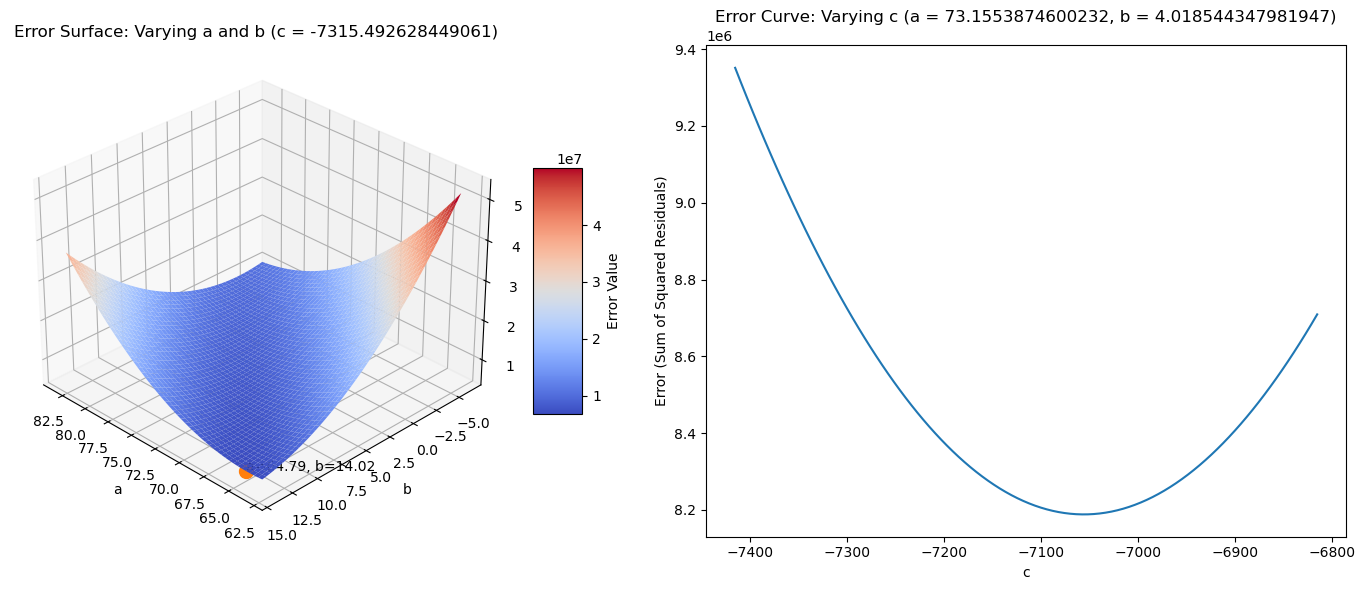

In [36]:
# Example usage with sample data
x = D3[0]['pupils_train'][:,0]
y = D3[0]['pupils_train'][:,1]
z = D3[0]['screen_coordinates_train'][:,1]  # Actual targets

# Set fixed values for a, b, and c (based on an example linear model)
a_fixed = results_linear_ts3[0]['model_y'][2]
b_fixed = results_linear_ts3[0]['model_y'][1]
c_fixed = results_linear_ts3[0]['model_y'][0]

# Plot the error surfaces
iml_util.plot_error_surfaces(a_fixed, b_fixed, c_fixed, x, y, z)

## 13 - evaluation of model parameters
**In short**
a and b are slopes, for x and y
c is the constant bias term, that determines where the prediction intercepts with the y-axis if a and b are zero.

**When modifying a and b:**

If b is fixed to 14.02 and a increases we get a smaller change than when a is fixed to 64.79 and b increases with the same amount. Basically b has a higher influence. 

**When modifying c:**

As SSE is punished by outliers, the further away we stray from ground truth,
the higher the error becomes. 
This is why the difference between c=7315 and c=7365 doesn't give as high
as error as the difference between c=6315 and c=6365.

The c term, is the bias term, which is a constant translation of the prediction function.
And thus it scales less than the slopes of a and b. A change to c is almost insignificant compared to the same changes to a and b. 


---
# Task 14 (hard): Evaluation(continued)♾️💡
1. Observe that it appears as the prediction could benefit from a smaller value of `c`
 than the least square model learned. Reflect on why this occurs.    - Why might adjusting the slope be more important for reducing the overall error?
    - How might this affect the optimization of $c$ compared to $a$ and $b$ when there is a large scale difference between inputs and labels?



**Note:** Hint: The model minimizes the total error by adjusting the parameters. Changing `a`
 and `b`
 affects how well the slope fits the data trend, while `c`
 just shifts the plane. 
The model tries to minimize the sum of squared errors $\sum \left( z - (ax + by + c) \right)^2$. If $x$ and $y$ are much smaller in scale than $z$ (ground truth), the terms $a \cdot x$ and $b \cdot y$ contribute less to the error than $c$.


---

## 14 answer

When mapping from small numbers (eye coordinates) to big numbers (screen coordinates) relatively, you get a very steep function. This means the coefficients (slopes) a and b are high, making them dominating terms. The constant c gets less significant and does not contribute much to the SSE.


Until now the models have been trained using the nine calibration points from the `grid`
 pattern. You will now increase the amount of training data by incoorporating all patterns except `circle`
. The pattern `circle`
 will be used for testing. In the cell below a dictionary `D3_mod`
 contains the training and test data similar to the structure of `D`
and `D3`
. . 

---
# Task 15 (medium): Adding more data♾️💡
1. Use the function`results_for_model`
 and the `LinearGaze`
 class to train a new model using `D3_mod`
. Use `plot_results_grid`
 to visualize the results and the function `plot_from_results_dict`
 to visualize the models.
2. Run the cell below to train and test the model and visualize the result. 


---

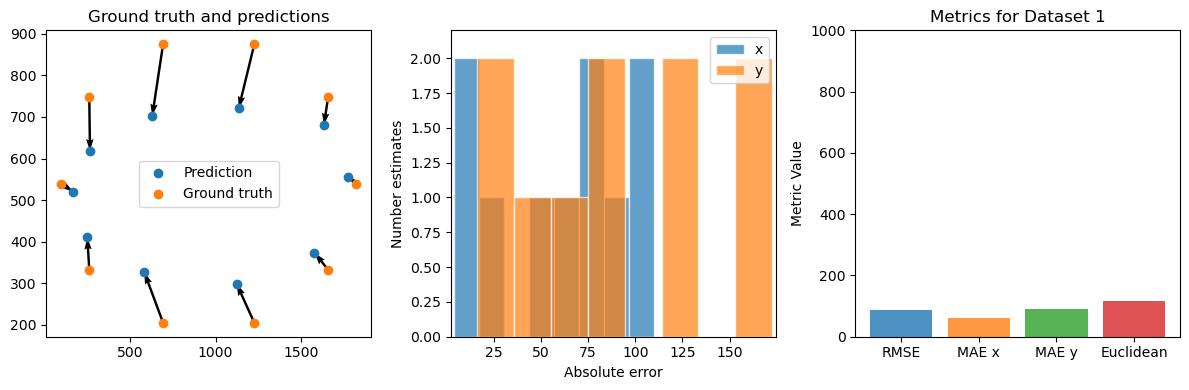

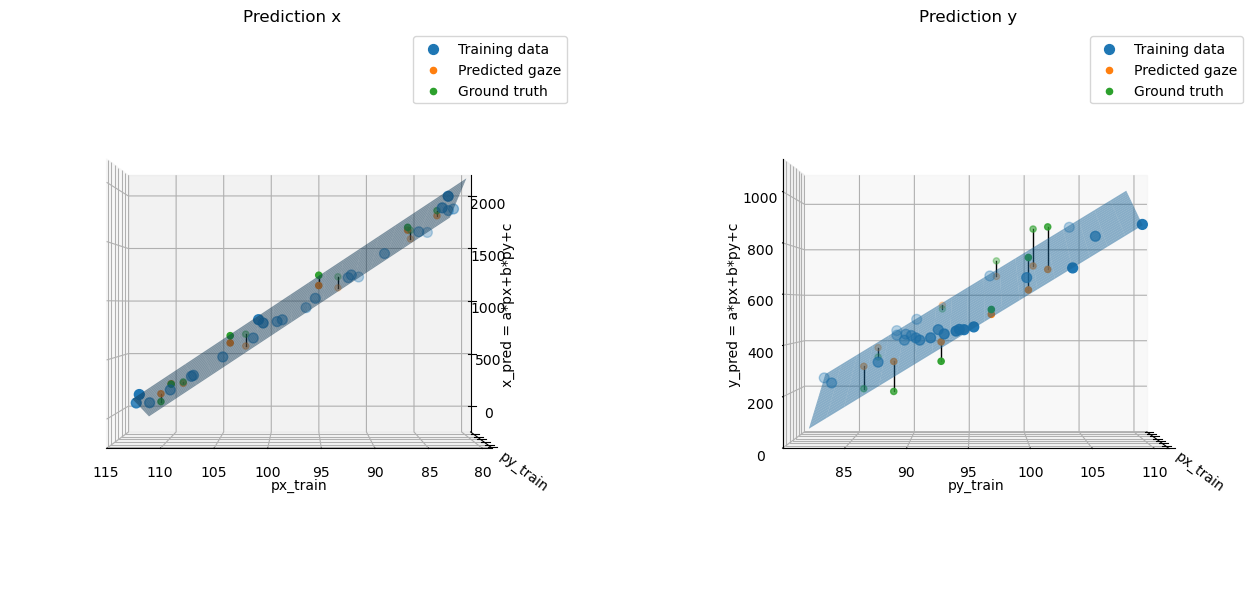

In [37]:
D3_mod = {}

ts3_p_train = D3[0]['pupils_test']
ts3_s_train = D3[0]['screen_coordinates_test'] 

ts3_p_test = D3[1]['pupils_test']
ts3_s_test = D3[1]['screen_coordinates_test']

for i in range(2,4):
    ts3_p_train = np.vstack((ts3_p_train,D3[i]['pupils_test']))
    ts3_s_train = np.vstack((ts3_s_train,D3[i]['screen_coordinates_test']))
    
D3_mod['pupils_train'] = ts3_p_train
D3_mod['screen_coordinates_train'] = ts3_s_train
D3_mod['pupils_test'] = ts3_p_test
D3_mod['screen_coordinates_test'] = ts3_s_test

D3_mod = [D3_mod]


results_mod = results_for_model(
    model=LinearGaze(), 
    dataset_train=D3_mod, 
    dataset_test=D3_mod,
    pupil_training_set='pupils_train',
    screen_training_set='screen_coordinates_train',
    pupil_test_set='pupils_test',
    screen_test_set='screen_coordinates_test',
    d_max=1
)

iml_util.plot_results_grid(results_mod, 1)

iml_util.plot_from_results_dict(results_mod[0], D3_mod[0])



---
# Task 16 (medium): Evaluate♾️💡
1. How does adding more training data affect the results.    - Does increasing the amount of training data _always_ improve the model's accuracy?
    - How does the variability in the data affect the model's ability to generalize when more data is added (elaborate on your reflection from Task 2.3)?
    - How could adding more data influence the optimization of the model parameters?




---

## 16. Evaluation of model trained on all data except circle, but tested on circle

**Does increasing data always improve accuracy:**
No, if shitty data is added this generally would make it worse "garbage in, garbage out". If a lot of data for a specific person is added it may bias our model such that it works very well on that person but it might make it less accurate for other people.

**How does variability in data affect models generalizations ability**:
If the goal is for the model to work well on one person then variability may not be desired. 

But if goal of the model is to predict well generally on example 1000 random persons then variability may be better.

**How adding more data influences the optimization**:

The least squares function will attempt to optimize the error based on every single point, including those added.
More data will thus change the fit of the line.
If the data added is bad, it will make a worse fit, compared to the ground truth, and thus
decrease generalizability, and vice versa.

If data is neither good or bad, but in general, more measurements can make us more confident 
that the least squares line, reflects the relationship between the features and the label.
And then leave more data for the testing dataset, to check if it is correct.


## Individual dataset
The pipeline of collecting data, training a model, testing, and evaluating it has been introduced. In this task, the data of your eyes will be used to train a model. Use the evaluation tools introduced in the assignment.
**Note:** **Important!** In case you do **not** want to share your data with the TA's for assessment, train and evaluate the models using your data and place images of the evaluation in the folder `data/output/individual`
. Comment out the coding cells for this part of the assigment for handin to allow TA's to run the entire notebook without errors, c.f. submitting details on [About the course](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)
. Submit the assignment without the data folder containing your data, and refer to evaluation images by name in your reflections.


---
# Task 17 (easy): Individual dataset
1. For reproduceability, write the _threshold_, _x_margin_, _y_margin_ and _side_ values that was used in the processing your data in Task 4 of the  Data preprocessing
 exercise.


---

In [39]:
#Note the values here
# Threshold = 
# x_margin = 
# y_margin = 
# side =


---
# Task 18 (medium): Train and test a model
1. Run the cell below to generate a dictionary of your own data.
2. Train an affine gaze estimation model using the pattern `grid`
.
3. Test the model on  all patterns.


---

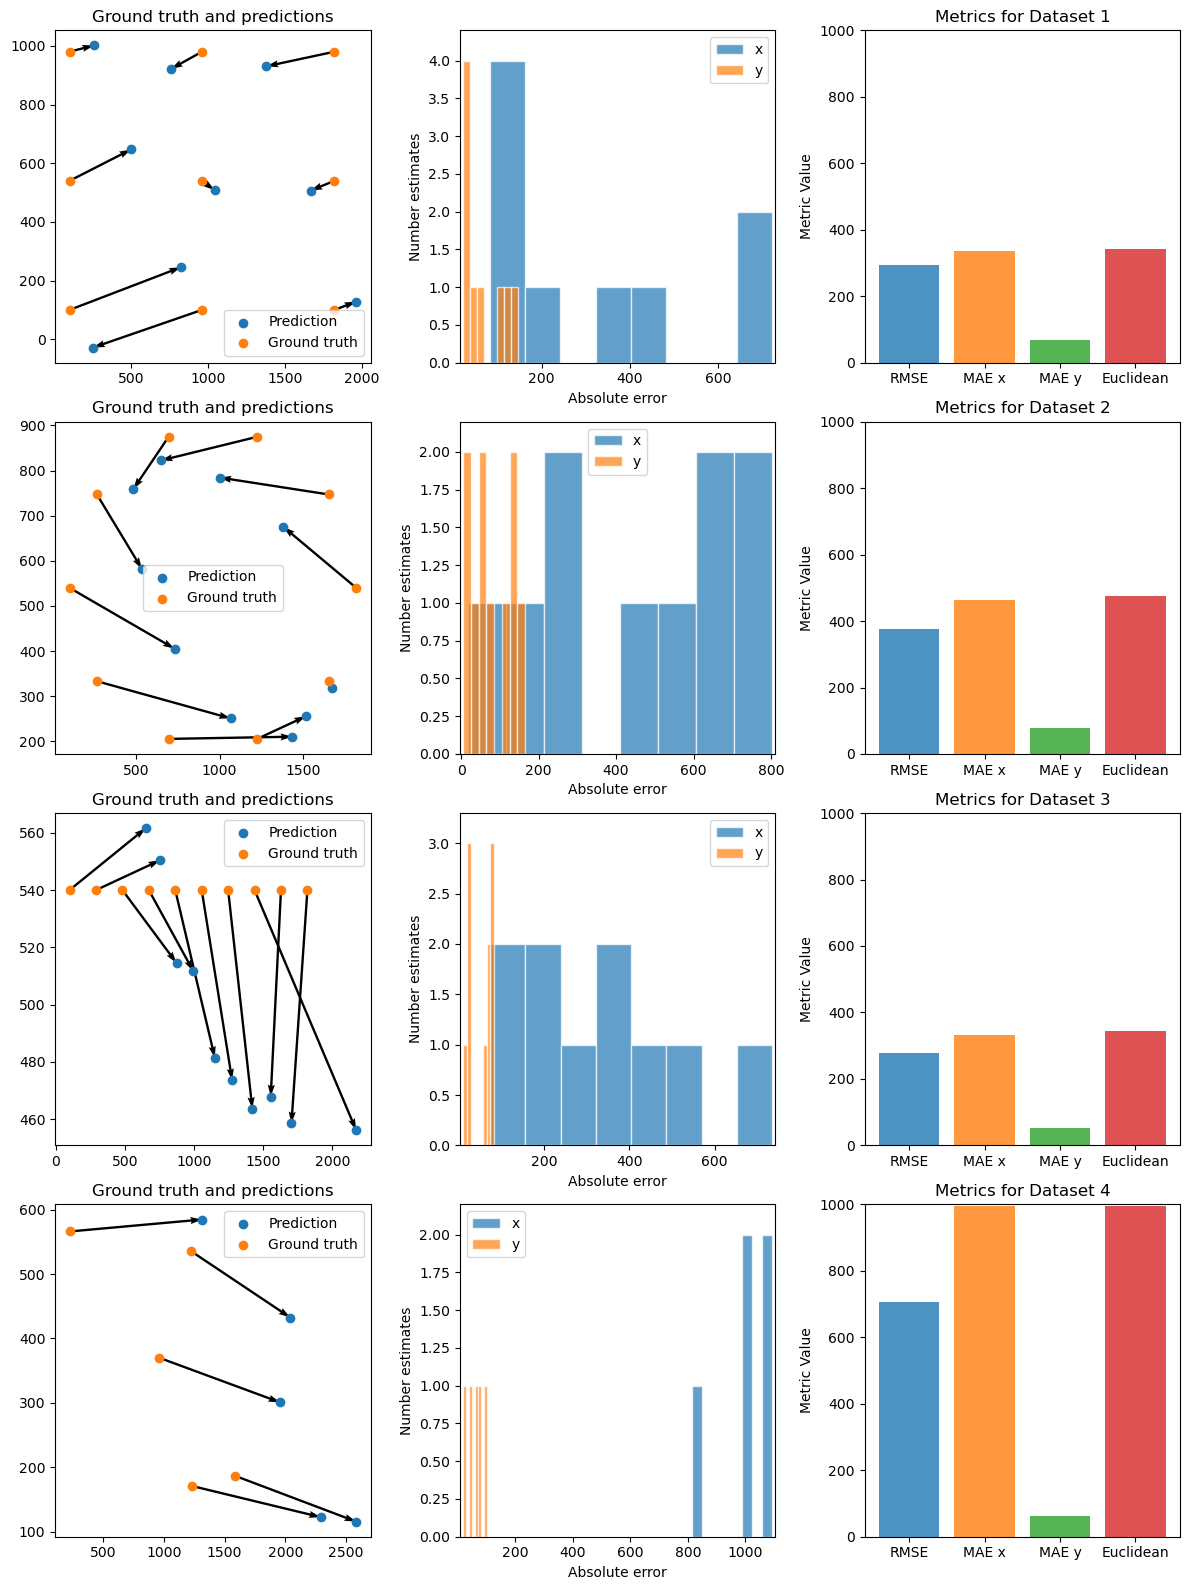

In [46]:
Thor_data = iml_util.gen_data_subject('test_subject_Thor')
results_linear_thor = results_for_model(LinearGaze(), Thor_data, Thor_data, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)
iml_util.plot_results_grid(results_linear_thor, 4)


---
# Task 19 (medium): Evaluate♾️💡
1. As in previous tasks, reflect on the results.


---

In [41]:
# Write your reflections here...

# Optional improvements
You may experience that the models behave differently on your dataset than on `test_subject_0`
 and `test_subject_3`
. This can be due to several factors, some of which you may have already reflected on in Task 8 in exercise Data preprocessing
. If you experience interesting behaviour in the predictions of your model you are of course welcome to explore it further such as:
- Different combinations of training set (use can use the creation of `D3_mod`
 for inspiration as to how to manipulate the combination of data for training and testing).     - If you have multiple data sets in your group, you can incoorporate those or use the ones provided, `test_subject_3`
 or `test_subject_1`
. 


- Other evaluation metrics
- Take inspiration from the optional exercises below, to explore your dataset further.


---
# Task 20 (medium): Explore your dataset👩‍💻♾️💡
1. Investigate your results and explore options for improving predictions and evaluation.


In this task, you will improve the model using normalization. In Task 13, you reflected on the effect of having a large scale difference between input and output. Use the data of `test_subject_3`
 in dictionary `D3`
. 

---
# Task 21 (medium): Scale the data👩‍💻**
1. Complete the functions `normalize`
 and `denormalize`
. 
1. Train and test a model using normalized data from `test_subject_3`
. (Note that for the _grid_ pattern you are using the same data for testing and training).
1. Visualize the results using the function `plot_results_grid`
. 


---

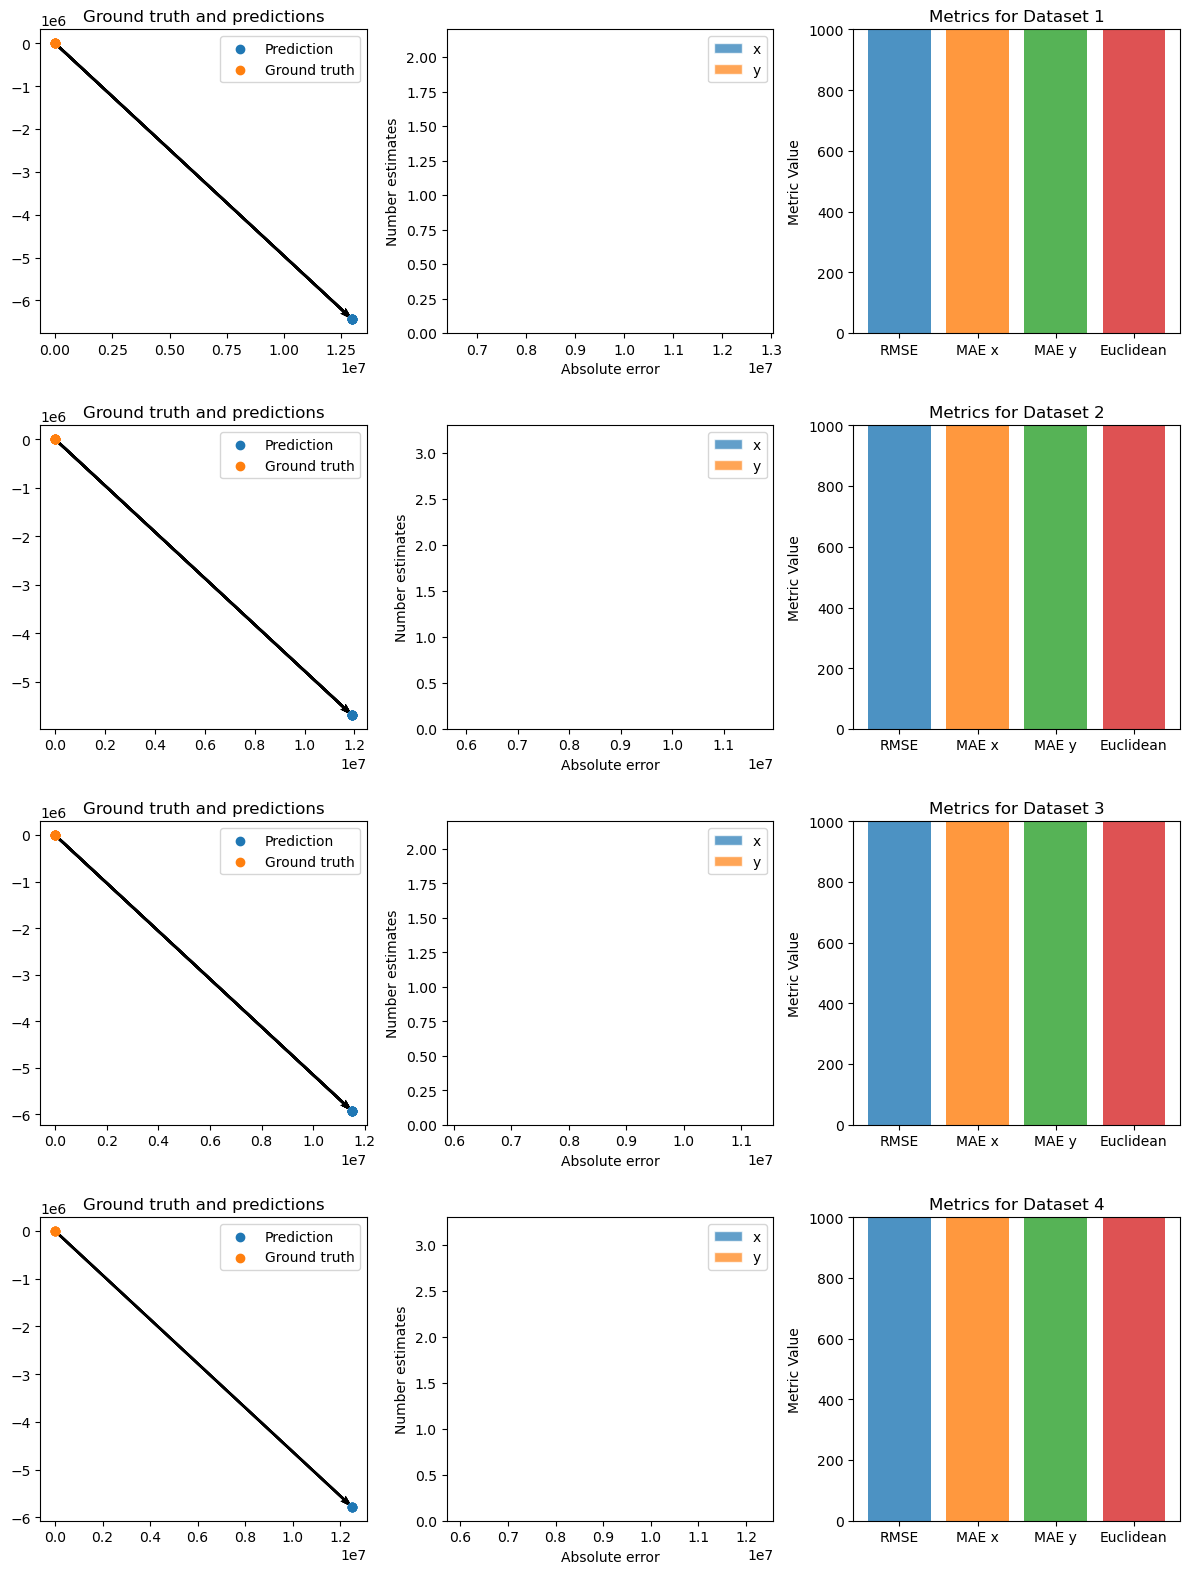

In [42]:
from sklearn.preprocessing import MinMaxScaler

def normalize(data_set):
    """
    Normalizes the pupil and screen coordinate data in the dataset using MinMaxScaler.
    
    Returns:
        d (list of dict): A list of dictionaries with normalized pupil and screen coordinate data.
        scaler (MinMaxScaler object): The fitted MinMaxScaler object used for normalization.
    """
    scaler = MinMaxScaler()
    
    # Normalize pupils and screen coordinates for training and testing
    for data in data_set:
        # Fit and transform training data (pupils and screen coordinates)
        data['pupils_train'] = scaler.fit_transform(data['pupils_train'])
        data['screen_coordinates_train'] = scaler.fit_transform(data['screen_coordinates_train'])
        
        # Transform test data based on the same scaler
        data['pupils_test'] = scaler.transform(data['pupils_test'])
        data['screen_coordinates_test'] = scaler.transform(data['screen_coordinates_test'])
    
    return data_set, scaler


def denormalize(dataset, scaler):
    """
    Denormalizes predicted and ground truth coordinates and calculates errors and performance metrics.
    
    Returns:
        d (dict): A dictionary where each key corresponds to a dataset index with denormalized predicted and ground truth coordinates.
    """
    results = {}
    
    for i, data in dataset.items():  # Correcting here to use .items() for dictionaries
        # Check if the data contains 'predicted' and 'ground_truth' keys
        if 'predicted' in data and 'ground_truth' in data:
            # Denormalize predicted and ground truth values
            predicted = scaler.inverse_transform(data['predicted'])
            ground_truth = scaler.inverse_transform(data['ground_truth'])
            
            # Calculate absolute errors
            errors = np.abs(predicted - ground_truth)
            
            # Calculate MSE, RMSE, MAE, and Euclidean distance
            mse = np.mean(errors ** 2, axis=0)
            rmse = np.sqrt(np.mean(mse))
            mae = np.mean(errors, axis=0)
            dist = np.mean(np.sqrt(np.sum(errors ** 2, axis=1)))
            
            # Store results in a dictionary
            results[i] = {
                'predicted': predicted,
                'ground_truth': ground_truth,
                'errors': errors,
                'mse': mse,
                'rmse': rmse,
                'dist': dist,
                'mae': mae
            }
        else:
            print(f"Warning: Missing 'predicted' or 'ground_truth' for dataset {i}")
    
    return results



# Write your code here for training, testing and visualizing results

D3 = iml_util.gen_data_subject('test_subject_3')

normalized_data, scaler = normalize(D3)

# Step 2: Train and test the model using the normalized data
results_normalized_thor = results_for_model(
    model=LinearGaze(),
    dataset_train=D,                       # Original training dataset
    dataset_test=normalized_data,          # Normalized test data (for all patterns)
    pupil_training_set='pupils_n_train',   # Training set key for pupils
    screen_training_set='screen_coordinates_train',  # Training set key for screen coordinates
    pupil_test_set='pupils_test',          # Test set key for pupils
    screen_test_set='screen_coordinates_test',  # Test set key for screen coordinates
    d_max=4                                # Maximum number of datasets (testing across all patterns)
)

# Step 3: Denormalize the results
denormalized_results = denormalize(results_normalized_thor, scaler)

# Step 4: Plot the denormalized results
iml_util.plot_results_grid(denormalized_results, 4)




---
# Task 22 (medium): Evaluation♾️💡
1. Evaluate the results based on the plots and compare to the results from Task 11.
2. What possible pitfalls could there be in normalizing the data?
3. The pattern _line_ though improved, occurs to perform the worst, use your previous reflection from Task 8 in exercise Data preprocessing
 to reflect on why.


---

In [43]:
#Write your reflections here...

## Improve the model
This final part of the exercise requires you to modify  the gaze model $f_{\mathbf{w}}(x,y)$ into a quadratic model. As in [Task 5](#task_model), you will create a model for each output coordinate, i.e. $x', y'$. 
**Note:** In this step you create one model for each output coordinate seperately but it is possible to create a single model that simultaneously maps the $x'$- and $y'$-coordinates. However, we leave it as an optional exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices.

Since the model is two-dimensional, the quadratic polynomial has  more model parameters than for one dimension model. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$
The design matrices then have the following form:

---
# Task 23 (medium): Model improvements👩‍💻💡
1. **Design matrix:** 
Argue why the desginmatrix for each output coordinate of the gaze mapping function is given by 

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.$$


2. **Implement model:** Implement the 2. order model and train it (calibrate) on each dataset.

3. **Evaluate:** Repeat the evaluation steps you did for the linear model above in [Task 2](#evaluation) (subtask 1-2). Additionally:
    - Create a barplot of the _rmse_ of both models for each dataset. Use the `bar_comparison_plot`
 function. 


4. **Compare with linear results:**
    - Is there a significant difference between the _rmse_'s of the linear and 2. order models? Explain why either is the case. Use your previous discussion of model limitations and error sources in your explanation.
    - Compare the scatter plots for the predictions vs. ground-truth for both models. Is there a qualitative difference in performance in some instances? Explain why either model performs better in particular cases and relate your answer to the previous question.




---

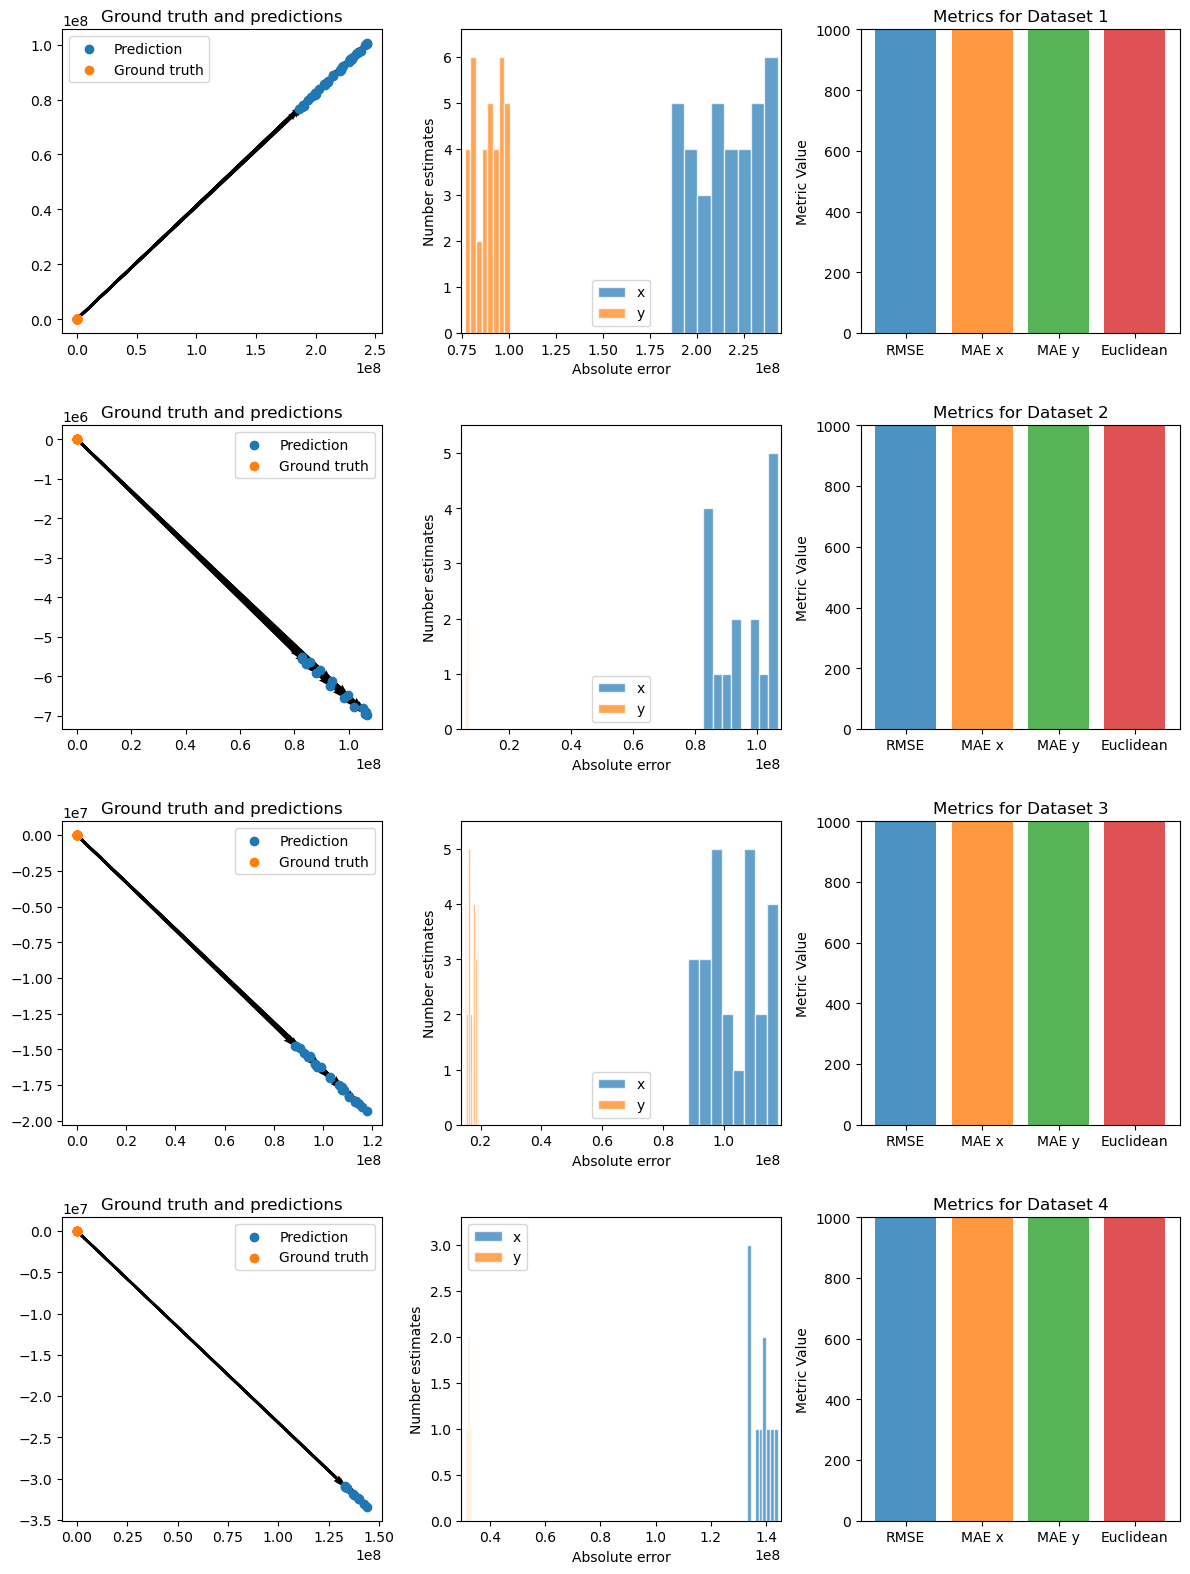

In [44]:
import numpy as np

# Step 1: Create the design matrix for quadratic terms
def get_design_matrix_quad(pupil_positions):
    """
    Constructs a quadratic design matrix.
    Parameters:
        pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).

    Returns:
        design_matrix (N x 6 numpy array) : n_samples, 6 features for the quadratic model.
    """
    px = pupil_positions[:, 0]
    py = pupil_positions[:, 1]
    
    # Construct the quadratic design matrix
    design_matrix = np.column_stack([
        px ** 2,              # Quadratic term for x^2
        py ** 2,              # Quadratic term for y^2
        px * py,              # Interaction term x * y
        px,                   # Linear term for x
        py,                   # Linear term for y
        np.ones(px.shape),    # Constant term
    ])
    
    return design_matrix

# Step 2: Implement the quadratic prediction function
def quad(param, x):
    """
    Prediction function using the quadratic terms.

    Parameters:
        param (1D array): Array of parameters [a, b, c, d, e, f] for the quadratic equation.
        x (1D array): Array [px, py] representing the pupil position.

    Returns:
        Predicted value based on the quadratic equation.
    """
    return param[0] + param[1] * x[0] + param[2] * x[1] + param[3] * x[0] * x[1] + param[4] * x[0] ** 2 + param[5] * x[1] ** 2

# Step 3: Implement the QuadGaze class
class QuadGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the QuadGaze model by fitting two quadratic regression models for x and y coordinates
        based on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinates x, y) representing
                  the true gaze positions on the screen.
        """
        pupils_train = dataset[pupil_training_set]
        positions_train = dataset[screen_training_set]

        # Create design matrix from pupil training data
        design_matrix = get_design_matrix_quad(pupils_train)
        
        # Solve for the parameters using least squares for both x and y coordinates
        self.model_x = np.linalg.lstsq(design_matrix, positions_train[:, 0], rcond=None)[0]  # Fit for x
        self.model_y = np.linalg.lstsq(design_matrix, positions_train[:, 1], rcond=None)[0]  # Fit for y

    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            x, y (float, float): Predicted gaze position (x, y) based on the quadratic model.
        """
        # Predict both x and y coordinates using the calibrated models
        predicted_x = quad(self.model_x, pupil)
        predicted_y = quad(self.model_y, pupil)
        
        return predicted_x, predicted_y

# Step 4: Evaluate the quadratic model
results_quad = results_for_model(
    model=QuadGaze(),
    dataset_train=D, 
    dataset_test=D, 
    pupil_training_set='pupils_n_train', 
    screen_training_set='screen_coordinates_train', 
    pupil_test_set='pupils_n_test', 
    screen_test_set='screen_coordinates_test', 
    d_max=4
)

# Step 5: Visualize the results
iml_util.plot_results_grid(results_quad, 4)



---
# Task 24 (medium): Evaluation♾️💡
1. Reflect on how the higher order model performs compared to the linear model.    - Does it reduce the error more effectively than the linear model?
    - Does it seem to overfit the training data? Why? Why not?
    - When plotting the residuals, do you notice any patterns for the higher-order model that are not present in the linear model?




---
**Submission**
For submission details click [here](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)

Use the [learnIt](https://learnit.itu.dk/)
 page for submission of the handin.

